In [ ]:
import os
import sys
import pandas as pd
import argparse
import warnings
from utils import *
from torch import nn
import copy
from tqdm import tqdm
import random
from data_loader import *
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import numpy as np
from http import HTTPStatus
import dashscope
from dashscope import Generation
import json
# import openai
from openai import OpenAI
from deepseek import DeepSeekClient
import os
from train import *
import pickle
from together import Together
from openai import OpenAI
warnings.filterwarnings("ignore")
#set deepseek and openai API keys



dashscope.api_key = 'YOUR KEY'
DEEPSEEK_API_KEY = 'YOUR KEY'
OPENAI_API_KEY = 'YOUR KEY'
LLAMA_API_KEY= 'YOUR KEY'

In [61]:
parser_train = argparse.ArgumentParser()
parser_train.add_argument('--seq_len', type=int, default=24*7)
parser_train.add_argument('--pred_len', type=int, default=24)
parser_train.add_argument('--label_len', type=int, default=0)
parser_train.add_argument('--train_length', type=int, default=17376)
parser_train.add_argument('--target', type=str, default='target')
parser_train.add_argument('--scale', type=bool, default=True)
parser_train.add_argument('--inverse', type=bool, default=True)
parser_train.add_argument('--num_epochs', type=int, default=1000)
parser_train.add_argument('--mode', type=str, default='parameter')
parser_train.add_argument('--quantiles', type=list, default=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95])
parser_train.add_argument('--lr', type=float, default=1e-4)
parser_train.add_argument('--patience', type=int, default=5)
parser_train.add_argument('--hidden_layers', type=list, default=[128,128,128])
parser_train.add_argument('--e2e_num_epochs', type=int, default=5)
parser_train.add_argument('--e2e_ft_lr', type=float, default=1e-6)
parser_train.add_argument('--e2e_lr', type=float, default=1e-7)#1e-7
parser_train.add_argument('--ft_lr', type=float, default=1e-4)
parser_train.add_argument('--batch_size', type=int, default=16)
parser_train.add_argument('--device', type=str, default='cuda:0' if torch.cuda.is_available() else 'cpu')
parser_train.add_argument('--epsion_p', type=float, default=1e1)
parser_train.add_argument('--epsion_l', type=float, default=1e1)
parser_train.add_argument('--metric_list', type=list, default=['pinball_loss','winkler_score_0.1','MAE','RMSE'])


parser_train.add_argument('--N_g', type=int, default=3)
parser_train.add_argument('--T', type=int, default=24)
parser_train.add_argument('--N', type=int, default=25)
parser_train.add_argument('--x_max', type=int, default=[1500,1800,2000])
parser_train.add_argument('--x_min', type=int, default=[0,0,0])
parser_train.add_argument('--z_pos_max', type=list, default=[500,700,800])
parser_train.add_argument('--z_neg_max', type=list, default=[500,700,800])
parser_train.add_argument('--z_pos_min', type=int, default=0)
parser_train.add_argument('--z_neg_min', type=int, default=0)
parser_train.add_argument('--r_neg', type=int, default=[800,800,500])
parser_train.add_argument('--r_pos', type=int, default=[800,800,500])
parser_train.add_argument('--alpha', type=list, default=[0.03 for i in range(24)]+[0.028 for i in range(24)]+[0.032 for i in range(24)])
parser_train.add_argument('--alpha_pos', type=list, default=[0.02 for i in range(24)]+[0.018 for i in range(24)]+[0.022 for i in range(24)])
parser_train.add_argument('--alpha_neg', type=list, default=[0.01 for i in range(24)]+[0.009 for i in range(24)]+[0.011 for i in range(24)])

parser_train.add_argument('--rho_z_pos', type=list, default=[0.05 for i in range(24)]+[0.045 for i in range(24)]+[0.055 for i in range(24)])
parser_train.add_argument('--rho_z_neg', type=list, default=[0.01 for i in range(24)]+[0.008 for i in range(24)]+[0.012 for i in range(24)])

parser_train.add_argument('--rho_r_pos', type=list, default=[0.1 for i in range(24)])
parser_train.add_argument('--rho_r_neg', type=list, default=[0.05 for i in range(24)])

parser_train.add_argument('--price_ratio_large', type=float, default=2.5)
parser_train.add_argument('--price_ratio_small', type=float, default=0.8)
parser_train.add_argument('--flag_dynamic_price', type=bool, default=False)
parser_train.add_argument('--flag_dynamic_mode', type=int, default=0)
parser_train.add_argument('--upper_quantiles', type=float, default=0.95)
parser_train.add_argument('--lower_quantiles', type=float, default=0.05)
parser_train.add_argument('--epsion', type=float, default=1)
parser_train.add_argument('--LLM_type', type=str, default='Qwen') #'euclidean' 'manhattan'
args = parser_train.parse_args(args=[])

In [62]:
train_load_data,train_load_loader=get_load_data(args,flag='train')
val_load_data,val_load_loader=get_load_data(args,flag='val')
test_load_data,test_load_loader=get_load_data(args,flag='test')

set_seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

../Data/GEF_data/data(3 year).csv
['month', 'weekday', 'hour', 'temp', 'load_1_day_before', 'load_2_day_before', 'load_3_day_before', 'load_4_day_before', 'load_5_day_before', 'load_6_day_before', 'load_7_day_before']
(693, 24, 11) (693, 24) (29, 24, 11) (29, 24)
(358, 24, 11)
(358, 24)
../Data/GEF_data/data(3 year).csv
['month', 'weekday', 'hour', 'temp', 'load_1_day_before', 'load_2_day_before', 'load_3_day_before', 'load_4_day_before', 'load_5_day_before', 'load_6_day_before', 'load_7_day_before']
(693, 24, 11) (693, 24) (29, 24, 11) (29, 24)
(335, 24, 11)
(335, 24)
../Data/GEF_data/data(3 year).csv
['month', 'weekday', 'hour', 'temp', 'load_1_day_before', 'load_2_day_before', 'load_3_day_before', 'load_4_day_before', 'load_5_day_before', 'load_6_day_before', 'load_7_day_before']
(693, 24, 11) (693, 24) (29, 24, 11) (29, 24)
(29, 24, 11)
(29, 24)


In [63]:
history_X_test = []
history_X_train = []
history_X_val = []

X_test=train_load_data.inverse_transform_X(test_load_data.X)
X_train=train_load_data.inverse_transform_X(train_load_data.X)
X_val=train_load_data.inverse_transform_X(val_load_data.X)

for i in range(len(X_test)//24):
    temp=X_test[i*24:(i+1)*24:,4:8]
    history_X_test.append(np.concatenate([temp[:, i] for i in range(temp.shape[1]-1, -1, -1)]))

for i in range(len(X_train)//24):
    temp=X_train[i*24:(i+1)*24:,4:8]
    history_X_train.append(np.concatenate([temp[:, i] for i in range(temp.shape[1]-1, -1, -1)]))

for i in range(len(X_val)//24):
    temp=X_val[i*24:(i+1)*24:,4:8]
    history_X_val.append(np.concatenate([temp[:, i] for i in range(temp.shape[1]-1, -1, -1)]))

print(np.shape(X_test))
print(np.shape(history_X_test))
print(np.shape(X_train))
print(np.shape(history_X_train))
print(np.shape(X_val))
print(np.shape(history_X_val))

(696, 11)
(29, 96)
(8592, 11)
(358, 96)
(8040, 11)
(335, 96)


In [64]:
input_size=train_load_data.X.shape[-1]
output_size=24
set_seed(42)

layer_sizes=[128,128,128]

input_size=train_load_data.X.shape[-1]
output_size=1
model_load=ANN_gaussian(input_size=input_size, hidden_layers=layer_sizes, output_size=output_size).to(device)
train_parameter(args, model_load, train_load_loader, val_load_loader,dir_best_model='../Model/best_ann_load.pt')

Epoch 0, Train Loss: 0.7720027593049136
Epoch [1/1000] Train Loss: 0.7720 Val Loss: 0.7282
Epoch [2/1000] Train Loss: 0.6608 Val Loss: 0.6028
Epoch [3/1000] Train Loss: 0.5162 Val Loss: 0.4283
Epoch [4/1000] Train Loss: 0.3167 Val Loss: 0.1953
Epoch [5/1000] Train Loss: 0.0609 Val Loss: -0.0990
Epoch [6/1000] Train Loss: -0.2893 Val Loss: -0.4934
Epoch [7/1000] Train Loss: -0.6568 Val Loss: -0.7070
Epoch [8/1000] Train Loss: -0.8241 Val Loss: -0.7556
Epoch [9/1000] Train Loss: -0.8528 Val Loss: -0.7997
Epoch [10/1000] Train Loss: -0.9192 Val Loss: -0.8057
Epoch 10, Train Loss: -0.9492454610087655
Epoch [11/1000] Train Loss: -0.9492 Val Loss: -0.8482
Epoch [12/1000] Train Loss: -0.9866 Val Loss: -0.8666
Epoch [13/1000] Train Loss: -1.0303 Val Loss: -0.8967
Epoch [14/1000] Train Loss: -1.0546 Val Loss: -0.9234
Epoch [15/1000] Train Loss: -1.0968 Val Loss: -0.9260
Epoch [16/1000] Train Loss: -1.1024 Val Loss: -0.9781
Epoch [17/1000] Train Loss: -1.1692 Val Loss: -0.9796
Epoch [18/1000] Tr

In [65]:
import numpy as np

def pinball_loss(y_true, y_pred, quantiles):
    if not isinstance(y_true, np.ndarray):
        y_true = np.array(y_true)
    
    y_true_expanded = np.expand_dims(y_true, axis=-1)
    errors = y_true_expanded - y_pred
    q_array = np.array(quantiles, dtype=y_pred.dtype)

    losses = np.maximum((q_array - 1) * errors, q_array * errors)
    loss = np.mean(losses, axis=0).sum()

    return loss

def quantile_normal_inverse_transform(mu, sigma, quantiles):
    if isinstance(mu, torch.Tensor):
        z = torch.tensor(quantiles, device=mu.device, dtype=mu.dtype)
        z_scores = torch.distributions.Normal(0, 1).icdf(z)  # shape [len(quantiles)]
        z_scores = z_scores.view(1, 1, -1)
        y_quantiles = mu.unsqueeze(-1) + sigma.unsqueeze(-1) * z_scores
    elif isinstance(mu, np.ndarray):
        z = norm.ppf(quantiles)  # shape [len(quantiles)]
        z_scores = z.reshape(1, 1, -1)
        y_quantiles = mu[:, :, np.newaxis] + sigma[:, :, np.newaxis] * z_scores
    
    return y_quantiles


In [66]:
test_input=torch.tensor(test_load_data.X).to(device).float()
test_pred_mu_nor, test_pred_var_nor = model_load(test_input)
test_pred_mu=test_load_data.scaler_y.inverse_transform(test_pred_mu_nor.detach().cpu().numpy())
test_pred_var=test_pred_var_nor.detach().cpu().numpy()*test_load_data.scaler_y.scale_
test_actual_nor=test_load_data.y
test_actual=test_load_data.scaler_y.inverse_transform(test_actual_nor)

print(MAE(test_actual, test_pred_mu),MAPE(test_actual, test_pred_mu),RMSE(test_actual, test_pred_mu))

quantiles=args.quantiles
test_quantiles=quantile_normal_inverse_transform(test_pred_mu, test_pred_var, quantiles)
print(pinball_loss(test_actual, test_quantiles, quantiles))

val_input=torch.tensor(val_load_data.X).to(device).float()
val_pred_mu_nor, val_pred_var_nor = model_load(val_input)
val_pred_mu=val_load_data.scaler_y.inverse_transform(val_pred_mu_nor.detach().cpu().numpy())
val_pred_var=val_pred_var_nor.detach().cpu().numpy()*val_load_data.scaler_y.scale_
val_actual_nor=val_load_data.y
val_actual=val_load_data.scaler_y.inverse_transform(val_actual_nor)

train_input=torch.tensor(train_load_data.X).to(device).float()
train_pred_mu_nor, train_pred_var_nor = model_load(train_input)
train_pred_mu=train_load_data.scaler_y.inverse_transform(train_pred_mu_nor.detach().cpu().numpy())
train_pred_var=train_pred_var_nor.detach().cpu().numpy()*train_load_data.scaler_y.scale_
train_actual_nor=train_load_data.y
train_actual=train_load_data.scaler_y.inverse_transform(train_actual_nor)



142.990060389727 0.04054062257193172 174.52570138295076
32601.732230395588


In [67]:
combined_train_data,combined_train_loader,combined_val_data,combined_val_loader,combined_test_data,combined_test_loader,combined_fine_tune_data,combined_fine_tune_loader = obtain_price(args,train_load_data,val_load_data,test_load_data)

data_iter = iter(combined_test_loader)
input_load_test, labels_load_test, alpha_test, alpha_z_test, rho_z_test, rho_r_test = next(data_iter)

alpha_sample=alpha_test[0,:].detach().cpu().numpy()
alpha_z_sample=alpha_z_test[0,:].detach().cpu().numpy()
rho_z_sample=rho_z_test[0,:].detach().cpu().numpy()
rho_r_sample=rho_r_test[0,:].detach().cpu().numpy()

set_seed(42)
cost_list=[]
optimization_module = Combined_SO_dispatch_GRB(args, alpha_sample, alpha_z_sample, rho_z_sample, rho_r_sample)
# solution_DA_grb, cost_DA_grb, cost_DA_grb_value=optimization_module.forward(test_pred_mu[0],test_pred_var[0],test_actual[0])
for i in range(29):
    _,_,cost=optimization_module.forward(test_pred_mu[i],test_pred_var[i],test_actual[i])
    cost_list.append(cost)
print('Average cost over 30 runs:', np.mean(cost_list))

Test data is not shuffled
Test data is not shuffled


Average cost over 30 runs: 3028.48773274922


In [68]:
SO_layer_cvxpy = DA_dispatch_SO_cvxpy(args)
intra_dispatch_cvxpy = RT_dispatch_cvxpy(args)

model_org =  Combined_SO_dispatch_cvxpy(SO_layer_cvxpy,intra_dispatch_cvxpy, copy.deepcopy(model_load)).to(device)
model_org.to(device)

cost_list_optnet= []
for i in range(29):
    test_pred_mu_tensor=torch.tensor(test_pred_mu[i],dtype=torch.float64).unsqueeze(0).to(device)
    test_pred_var_tensor=torch.tensor(test_pred_var[i],dtype=torch.float64).unsqueeze(0).to(device)
    test_actual_tensor=torch.tensor(test_actual[i],dtype=torch.float64).unsqueeze(0).to(device)

    alpha_sample_torch=torch.tensor(alpha_sample,dtype=torch.float64).unsqueeze(0).to(device)
    alpha_z_sample_torch=torch.tensor(alpha_z_sample,dtype=torch.float64).unsqueeze(0).to(device)
    rho_z_sample_torch=torch.tensor(rho_z_sample,dtype=torch.float64).unsqueeze(0).to(device)
    rho_r_sample_torch=torch.tensor(rho_r_sample,dtype=torch.float64).unsqueeze(0).to(device)
    set_seed(42)
    solution_DA, solution_RT, cost = model_org.forward(
                        args, test_pred_mu_tensor,test_pred_var_tensor, test_actual_tensor,
                        alpha_sample_torch, alpha_z_sample_torch, rho_z_sample_torch, rho_r_sample_torch
                    )
    cost_list_optnet.append(cost.detach().cpu().numpy())
print('Average cost over 30 runs (OptNet):', np.mean(cost_list_optnet))


Average cost over 30 runs (OptNet): 3028.487733174566


In [69]:
from E2E import E2E_test_ideal,E2E_test,E2E_train

In [70]:
from E2E import E2E_test_ideal,E2E_test,E2E_train
_,_,cost_list_ideal,_,_,_=E2E_test_ideal(args, model_org, combined_test_loader, train_load_data.scaler_y)
_,_,cost_list_train_ideal,_,_,_=E2E_test_ideal(args, model_org, combined_train_loader, train_load_data.scaler_y)
_,_,cost_list_val_ideal,_,_,_=E2E_test_ideal(args, model_org, combined_val_loader, train_load_data.scaler_y)

Test Objective: 2392.189740770122
Test Objective: 2650.9600326568443
Test Objective: 2622.024603134539
Test Objective: 2452.369167679563
Test Objective: 2364.880033939213
No more data to read.
Test Objective: 2284.506774159131
Test Objective: 2247.082523717896
Test Objective: 2236.2070249696026
Test Objective: 2262.8930252153823
Test Objective: 2224.849023435543
Test Objective: 2242.131774289995
Test Objective: 2308.9750264611066
Test Objective: 2229.8297750371958
Test Objective: 2270.1205253678563
Test Objective: 2295.593524911773
Test Objective: 2264.491526149967
Test Objective: 2249.119024886811
Test Objective: 2351.0057758291214
Test Objective: 2171.1572728749243
Test Objective: 2306.5100258642424
Test Objective: 2289.2892756928554
Test Objective: 2335.115774776379
Test Objective: 2240.5287737908757
Test Objective: 2247.936270467775
Test Objective: 2287.7602780300904
Test Objective: 2251.805274657032
Test Objective: 2187.4802729311095
Test Objective: 2324.818026683723
No more data 

In [71]:

_,_, cost_list_test,forecasts_mu_test,forecasts_var_test,actual_load_test=E2E_test(args, model_org, combined_test_loader, train_load_data.scaler_y)
_,_, cost_list_val,forecasts_mu_val,forecasts_var_val,actual_load_val=E2E_test(args, model_org, combined_val_loader, train_load_data.scaler_y)
_,_, cost_list_train,forecasts_mu_train,forecasts_var_train,actual_load_train=E2E_test(args, model_org, combined_train_loader, train_load_data.scaler_y)

Test Objective: 2730.35968582262
Test Objective: 3305.7642859033117
Test Objective: 3068.0842011297345
Test Objective: 2950.1338194991868
Test Objective: 2679.8912313155965
No more data to read.
Test Objective: 2703.5863327665643
Test Objective: 2965.926567911718
Test Objective: 3048.9472337338307
Test Objective: 2806.7592325378864
Test Objective: 2507.9257192378036
Test Objective: 2851.048582467948
Test Objective: 2795.15679230802
Test Objective: 2830.9599999995753
Test Objective: 2715.8539905395646
Test Objective: 2651.811947611509
Test Objective: 2832.5235042294244
Test Objective: 2634.4148088930333
Test Objective: 2673.897786105424
Test Objective: 2908.340094538465
Test Objective: 2808.547674290036
Test Objective: 3076.4671153825407
Test Objective: 2624.9618634900326
Test Objective: 2730.389420289868
Test Objective: 2616.5212865831313
Test Objective: 2904.683253898713
Test Objective: 2535.8268927700515
No more data to read.
Test Objective: 2748.828798809909
Test Objective: 2596.182

In [72]:
model_e2e_deterministic=E2E_train(args, model_org, combined_train_loader, combined_test_loader,train_load_data.scaler_y)
_,_, cost_list_test_optnet,forecasts_mu_test_optnet,forecasts_var_test_optnet,actual_load_test_optnet=E2E_test(args, model_e2e_deterministic, combined_test_loader, train_load_data.scaler_y, time_flag=True)
_,_,cost_list_val_optnet,forecasts_mu_val_optnet,forecasts_var_val_optnet,actual_load_val_optnet=E2E_test(args, model_e2e_deterministic, combined_val_loader, train_load_data.scaler_y, time_flag=True)
_,_,cost_list_train_optnet,forecasts_mu_train_optnet,forecasts_var_train_optnet,actual_load_train_optnet=E2E_test(args, model_e2e_deterministic, combined_train_loader, train_load_data.scaler_y, time_flag=True)

e2e epoch: 0
e2e epoch: 1
e2e epoch: 2
Test Objective: 2704.250973881428
Test Objective: 3177.762683433777
Test Objective: 3061.705610649421
Test Objective: 2938.5025480871604
Test Objective: 2670.9718966554324
No more data to read.
Test Objective: 2654.4248121454657
Test Objective: 2924.225576183768
Test Objective: 3017.2229407662217
Test Objective: 2781.599785917564
Test Objective: 2517.7338321324214
Test Objective: 2806.020845850208
Test Objective: 2755.061967364659
Test Objective: 2789.2137908789446
Test Objective: 2676.5499862374772
Test Objective: 2615.6018988374717
Test Objective: 2812.7129893938054
Test Objective: 2607.2781737221503
Test Objective: 2660.6346650445057
Test Objective: 2875.194776444027
Test Objective: 2757.848757176364
Test Objective: 3028.467261039173
Test Objective: 2628.020639760345
Test Objective: 2675.212938115553
Test Objective: 2593.0172603118826
Test Objective: 2842.762088488345
Test Objective: 2528.688633452867
No more data to read.
Test Objective: 2704.

In [73]:
from model import *
from E2E import *

In [74]:
if isinstance(train_load_data.scaler_y, StandardScaler):
    scale=train_load_data.scaler_y.scale_
    mean=train_load_data.scaler_y.mean_
elif isinstance(train_load_data.scaler_y, MinMaxScaler):
    scale=train_load_data.scaler_y.data_max_-train_load_data.scaler_y.data_min_
    mean=train_load_data.scaler_y.data_min_

cost_list_test_insert=[cost_list_test[i]-cost_list_ideal[i] for i in range(len(cost_list_test))]
actual_load_test_insert=[tensor.detach().cpu().numpy() for tensor in actual_load_test]
pred_mu_test_insert=[tensor.detach().cpu().numpy() for tensor in forecasts_mu_test]
pred_var_test_insert=[tensor.detach().cpu().numpy() for tensor in forecasts_var_test]

cost_list_val_insert=[cost_list_val[i]-cost_list_val_ideal[i] for i in range(len(cost_list_val))]
actual_load_val_insert=[tensor.detach().cpu().numpy() for tensor in actual_load_val]
pred_mu_val_insert=[tensor.detach().cpu().numpy() for tensor in forecasts_mu_val]
pred_var_val_insert=[tensor.detach().cpu().numpy() for tensor in forecasts_var_val]

cost_list_train_insert=[cost_list_train[i]-cost_list_train_ideal[i] for i in range(len(cost_list_train))]
actual_load_train_insert=[tensor.detach().cpu().numpy() for tensor in actual_load_train]
pred_mu_train_insert=[tensor.detach().cpu().numpy() for tensor in forecasts_mu_train]
pred_var_train_insert=[tensor.detach().cpu().numpy() for tensor in forecasts_var_train]

cost_list_test_optnet_insert=[cost_list_test_optnet[i]-cost_list_ideal[i] for i in range(len(cost_list_test_optnet))]
actual_load_test_optnet_insert=[tensor.detach().cpu().numpy() for tensor in actual_load_test_optnet]
pred_mu_test_optnet_insert=[tensor.detach().cpu().numpy() for tensor in forecasts_mu_test_optnet]
pred_var_test_optnet_insert=[tensor.detach().cpu().numpy() for tensor in forecasts_var_test_optnet]

cost_list_val_optnet_insert=[cost_list_val_optnet[i]-cost_list_val_ideal[i] for i in range(len(cost_list_val_optnet))]
actual_load_val_optnet_insert=[tensor.detach().cpu().numpy() for tensor in actual_load_val_optnet]
pred_mu_val_optnet_insert=[tensor.detach().cpu().numpy() for tensor in forecasts_mu_val_optnet]
pred_var_val_optnet_insert=[tensor.detach().cpu().numpy() for tensor in forecasts_var_val_optnet]

cost_list_train_optnet_insert=[cost_list_train_optnet[i]-cost_list_train_ideal[i] for i in range(len(cost_list_train_optnet))]
actual_load_train_optnet_insert=[tensor.detach().cpu().numpy() for tensor in actual_load_train_optnet]
pred_mu_train_optnet_insert=[tensor.detach().cpu().numpy() for tensor in forecasts_mu_train_optnet]
pred_var_train_optnet_insert=[tensor.detach().cpu().numpy() for tensor in forecasts_var_train_optnet]

history_X_insert_train=[np.concatenate([history_X_train[i], pred_mu_train_optnet_insert[i]]) for i in range(len(pred_mu_train_optnet_insert))]
history_X_insert_val=[np.concatenate([history_X_val[i], pred_mu_val_optnet_insert[i]]) for i in range(len(pred_mu_val_optnet_insert))]
history_X_insert_test=[np.concatenate([history_X_test[i], pred_mu_test_optnet_insert[i]]) for i in range(len(pred_mu_test_optnet_insert))]


db_train = CurveDictDB()
cur_id_start = max(db_train.data.keys(), default=0) + 1
for i, (cost, pred_mu,pred_var, fine_tuned_mu,fine_tuned_var, actual_load, history_X) in enumerate(zip(
                    cost_list_train_insert, 
                     pred_mu_train_insert,pred_var_train_insert, 
                     pred_mu_test_optnet_insert,pred_var_test_optnet_insert, 
                     actual_load_train_insert,history_X_insert_train)):
    record = {
        'id': cur_id_start + i,
        'flag': 0,
        'prompt': '',
        'load': pred_mu,
        'pred_var': pred_var,
        'fine_tuned_load': fine_tuned_mu,
        'fine_tuned_var': fine_tuned_var,
        'cost': cost,
        'actual_load': actual_load,
        'cost_reduction': 0, # 1代表成本比fine tune前低
        'history_X': history_X
    }
    db_train.insert(record)

db_val = CurveDictDB()
cur_id_start_val = max(db_val.data.keys(), default=0) + 1
for i, (cost, pred_mu, pred_var, fine_tuned_mu,fine_tuned_var, actual_load, history_X) in enumerate(zip(
    cost_list_val_insert, 
    pred_mu_val_insert, pred_var_val_insert,
    pred_mu_train_optnet_insert, pred_var_train_optnet_insert, 
    actual_load_val_optnet_insert, history_X_insert_val)):
    record = {
        'id': cur_id_start_val + i,
        'flag': 0,
        'prompt': '',
        'load': pred_mu,
        'pred_var': pred_var,
        'fine_tuned_load': fine_tuned_mu,
        'fine_tuned_var': fine_tuned_var,
        'cost': cost,
        'actual_load': actual_load,
        'cost_reduction': 0,
        'history_X': history_X
    }
    db_val.insert(record)


In [75]:
def generate_prompt_sys(args,data):
    # Return English prompt
    prompt = (
        f"You are a power dispatch expert. There are {args.N_g} generating units:\n"
        f"Unit 1: {args.x_min}~{args.x_max} MW, "
        f"Unit 2: {args.x_min}~{args.x_max} MW, "
        f"Unit 3: {args.x_min}~{args.x_max} MW.\n"
        f"Unit 1 generation cost: {args.alpha[0:args.T]}*x RMB/kWh, "
        f"Unit 2 generation cost: {args.alpha[args.T:2*args.T]}*x RMB/kWh, "
        f"Unit 3 generation cost: {args.alpha[args.T*2:args.T*3]}*x RMB/kWh.\n"
        f"Unit 1 positive reserve limit: {args.rho_z_pos[0:args.T]} RMB/kWh, "
        f"Unit 1 negative reserve limit: {args.rho_z_neg[0:args.T]} RMB/kWh.\n"
        f"Unit 2 positive reserve limit: {args.rho_z_pos[args.T:2*args.T]} RMB/kWh, "
        f"Unit 2 negative reserve limit: {args.rho_z_neg[args.T:2*args.T]} RMB/kWh.\n"
        f"Unit 3 positive reserve limit: {args.rho_z_pos[args.T*2:args.T*3]} RMB/kWh, "
        f"Unit 3 negative reserve limit: {args.rho_z_neg[args.T*2:args.T*3]} RMB/kWh.\n"   
        f"Fine tune the predicted load curve to minimize the cost of generation, you can be brave to make bold adjustments within safety limits.\n"
        #f"Predicted load: {data['load']}\n"
        #f"Predicted standard deviation: {data['pred_var']}\n"
    )
    
    return prompt

In [76]:
output_require_prompt = """Please learn from the few-shot record and derived a combined strategy to adjust the original load curve.
    You can only change several time points, and each point can only be changed within ±10% of the original value.
    Output a Python function named "adjustment_strategy" that implements the optimization strategy. The function should take the original load curve as input and return a list of 24 delta values (changes to apply).

    Requirements:
    1. Define a function: def adjustment_strategy(original_load: list, original_var: list)-> deltas_mean:list,deltas_std:list.
    2. The function must return a list of 24 numbers (deltas)
    3. Use only basic Python operations (no external libraries)
    4. Include comments explaining your strategy
    5. Example:
        def adjustment_strategy(original_load,original_var):
            deltas_mean = [0] * 24
            deltas_std = [0] * 24
            if 20 <= i <22:
                deltas_mean[i] = -original_load[i] * 0.02  # Reduce by 2%
                deltas_std[i] = -original_var[i] * 0.01  # Reduce by 2%
            return deltas_mean, deltas_std
    """

### main

In [77]:
def few_shot_prompt_generate(args, similar_days, max_strategies=10, max_attempts=5,failure_strategy=None):
    """
    Generate few-shot prompts for small-scale adjustment strategies.
    Adjusts no more than 5 time points at a time, gradually building a strategy library.

    Args:
        args: Model arguments/parameters
        similar_days: List of data for similar days
        max_strategies: Maximum number of effective strategies
        max_attempts: Maximum number of attempts

    Returns:
        tuple: (Strategy history string, List of valid strategies)
    """
    # Get average load of similar days
    similar_day_mu = np.mean([day['load'] for day in similar_days], axis=0)
    similar_day_var = np.mean([day['pred_var'] for day in similar_days], axis=0)

    similar_day_actual = np.mean([day['actual_load'] for day in similar_days], axis=0)
    
    # similar_day_actual_load_numpy = train_load_data.scaler_y.inverse_transform(np.array(similar_day_actual_nor).reshape(1,-1))[0]

    _,_, original_cost = optimization_module.forward(similar_day_mu, similar_day_var, similar_day_actual)

    original_cost = original_cost.item()
    
    # Strategy generation prompt template
    sim_data = {"load": similar_day_mu, "pred_var": similar_day_var}
    system_prompt = generate_prompt_sys(args, sim_data)
    higher_flag = "higher" if sum(np.array(similar_day_mu) - np.array(similar_day_actual)) > 0 else "lower"
    reduce_flag = "reduce" if higher_flag == "higher" else "increase"
    system_prompt += f"""\n The maximum load occurs at {int(np.argmax(similar_day_mu))} hour, and the minimum load occurs at {int(np.argmin(similar_day_mu))} hour.\n\n"""
    system_prompt += f"""
    You have two approach to reduce cost:

    1. Compare the actual value and forecast of the similar day, try to learn some errors reduce strategy. In this case, the similar day forecast is {higher_flag} than actual, so you can try to {reduce_flag} the load in some hours to reduce cost.
    2. Compare the future positive and negative reserve prices.
    - If the positive reserve price is much higher than the negative reserve price, you should schedule more generation in the day-ahead market.
    - If the negative reserve price is higher, schedule less generation to reduce potential costs.
    """

    if failure_strategy==None:
        pass
    else:
        system_prompt='Here is failed strategy:\n'+failure_strategy

    output_require_prompt = f"""
    You are an expert in electricity load curve optimization. Your task is to generate Python functions that implement small-scale optimization strategies for daily electricity load curves.

    Requirements:
    1. Generate exactly 8 distinct Python functions named "strategy_1", "strategy_2", "strategy_3", "strategy_4", "strategy_5", "strategy_6", "strategy_7", and "strategy_8".
    2. The strategy should focus on a *different* part of the load curve, avoiding concentrating all changes in same time intervals.
    2. Each function must:
       - Take two arguments: the original load curve (list of 24 hourly values) and the original variance curve (list of 24 hourly values)
       - Return two lists of 24 numbers (deltas) representing adjustments to mean and variance to each hour
    3. Each strategy must:
       - Adjust no more than 5 time points (hours)
       - Target adjacent hours (e.g., 7pm to 9pm)
       - Keep adjustments within ±10% of the original value at each hour
       - Try to be different from other strategies.
    4. Use only basic Python operations (no external libraries)
    5. Include comments explaining:
       - Which specific hours are targeted
       - Why this strategy might reduce electricity costs
    6. Example strategies:

    Example 1: Reduce evening peak
    def strategy_1(original_load, original_var):
        # Focus: Reduce peak at 18:00 and 19:00 only
        deltas_mean = [0] * 24
        deltas_std = [0] * 24
        # Only adjust hours 18 and 19
        deltas_mean[18] = -original_load[18] * 0.05  # Reduce by 2%
        deltas_mean[19] = -original_load[19] * 0.05  # Reduce by 2%
        deltas_std[18] = -original_var[18] * 0.03  # Reduce by 2%
        deltas_std[19] = -original_var[19] * 0.03  # Reduce by 2%

        return deltas_mean, deltas_std

    Example 2: Shift load from afternoon to late afternoon
    def strategy_2(original_load, original_var):
        # Focus: Shift load from afternoon to late afternoon
        deltas_mean = [0] * 24
        deltas_std = [0] * 24
        # Only adjust hours 14 and 15
        deltas_mean[14] = -original_load[14] * 0.04  # Reduce at 14:00
        deltas_mean[15] = original_load[14] * 0.04   # Increase at 15:00
        deltas_std[14] = -original_var[14] * 0.02  # Reduce at 14:00
        deltas_std[15] = original_var[14] * 0.02   # Increase at 15:00
        return deltas_mean, deltas_std

    Example 3: Increase off-peak consumption
    def strategy_3(original_load, original_var):
        # Focus: Slightly increase off-peak at 2:00 and 3:00
        deltas_mean = [0] * 24
        deltas_std = [0] * 24
        # Only adjust hours 2 and 3
        deltas_mean[2] = original_load[2] * 0.03  # Increase by 1%
        deltas_mean[3] = original_load[3] * 0.03  # Increase by 1%
        deltas_std[2] = original_var[2] * 0.03  # Increase by 1%
        deltas_std[3] = original_var[3] * 0.03  # Increase by 1%
        return deltas_mean, deltas_std

    Example 4: Flatten morning peak
    def strategy_4(original_load, original_var):
        # Focus: Reduce morning peak at 8:00 and shift to 9:00
        deltas_mean = [0] * 24
        deltas_std = [0] * 24
        # Only adjust hours 8 and 9
        deltas_mean[8] = -original_load[8] * 0.05  # Reduce at 8:00
        deltas_mean[9] = original_load[8] * 0.05   # Increase at 9:00
        deltas_std[8] = -original_var[8] * 0.02  # Reduce at 8:00
        deltas_std[9] = original_var[8] * 0.02   # Increase at 9:00
        return deltas_mean, deltas_std

    Example 5: Smooth transition between peak and off-peak
    def strategy_5(original_load,original_var):
        # Focus: Smooth transition from evening to night (20:00-21:00)
        deltas_mean = [0] * 24
        deltas_std = [0] * 24
        # Only adjust hours 20 and 21
        deltas_mean[20] = -original_load[20] * 0.06  # Reduce at 20:00
        deltas_mean[21] = -original_load[20] * 0.06   # Increase at 21:00
        deltas_std[20] = -original_var[20] * 0.03 # Reduce at 20:00
        deltas_std[21] = -original_var[20] * 0.03   # Increase at 21:00
        return deltas_mean, deltas_std
    """
    
    # Store valid strategies
    valid_strategies = []
    strategy_history = ""
    attempt_count = 0
    full_prompt = ''
    while (len(valid_strategies) < max_strategies and attempt_count < max_attempts) or (len(valid_strategies) < int(max_strategies)/2 and attempt_count < 10):
        attempt_count += 1
        print(f"Strategy generation attempt #{attempt_count} (Current valid strategies: {len(valid_strategies)}/{max_strategies})")
        if valid_strategies != []:
            history_snippet = 'Here are some previously discovered effective small-scale adjustment strategies:\n, you are modified based on these strategies or regenerate new strategies.\n'
            for i in range(len(valid_strategies)):
                history_snippet += (f"Strategy {i+1}:\n{valid_strategies[i]['code']}\n\n")
        else:
            history_snippet = "No previously discovered effective small-scale adjustment strategies."
        if attempt_count >= int(max_attempts)/2:
            print('Give actual value')
            full_prompt += (f"SYSTEM INSTRUCTIONS:\n{system_prompt}\n\n"
                            f"HISTORICAL CONTEXT:\n{history_snippet}\n\n"
                            f"This is your FINAL attempt for this similar day. The actual load is {similar_day_actual}. Use all your knowledge and experience to produce the best possible optimized load curves.\n\n"
                            f"TASK REQUIREMENTS:\n{output_require_prompt}\n\n")
        else:
            full_prompt += (
                            f"SYSTEM INSTRUCTIONS:\n{system_prompt}\n\n"
                            f"HISTORICAL CONTEXT:\n{history_snippet}\n\n"
                            f"TASK REQUIREMENTS:\n{output_require_prompt}\n\n")
        try:
            if args.LLM_type == 'Qwen':
                response = Generation.call(
                model="qwen-plus",
                messages=[
                    {"role": "system", "content": full_prompt},
                ],
                parameters={
                    "temperature": 0.5,
                    "max_tokens": 3072,
                    "top_k": 20
                }
                )
                raw_text = response.output.text.strip()
                func_code = extract_pure_code(raw_text)

            elif args.LLM_type == 'Deepseek':
                client = OpenAI(api_key=DEEPSEEK_API_KEY,
                base_url="https://api.deepseek.com")

                response = client.chat.completions.create(
                    model="deepseek-chat",
                    messages=[
                        {"role": "system", "content": full_prompt},
                    ],
                    temperature=0.7,
                    max_tokens=3072,
                    stream=False,
                )

                raw_text = response.choices[0].message.content.strip()
                func_code = extract_pure_code(raw_text)

            elif args.LLM_type == 'Llama':
                client = Together(api_key=LLAMA_API_KEY)
                response = client.chat.completions.create(
                    model="meta-llama/Llama-4-Scout-17B-16E-Instruct",  # Can be replaced with other Llama versions
                    messages=[
                    {"role": "system", "content": full_prompt},
                ],
                temperature=1.2,
                max_tokens=3072,
                stream=False,
                )
                raw_text = response.choices[0].message.content.strip()
                func_code = extract_pure_code(raw_text)

            # Execute all strategy functions (evaluate separately)
            similar_day_mu_nor = train_load_data.scaler_y.transform(np.array(similar_day_mu).reshape(-1,1)).flatten()
            if isinstance(train_load_data.scaler_y, StandardScaler):
                similar_day_var_nor = np.array(similar_day_var).flatten()/train_load_data.scaler_y.scale_
            elif isinstance(train_load_data.scaler_y, MinMaxScaler):
                similar_day_var_nor = np.array(similar_day_var).flatten()/(train_load_data.scaler_y.data_max_-train_load_data.scaler_y.data_min_)
            strategy_results = evaluate_individual_strategies(
                func_code, 
                similar_day_mu_nor.tolist(),
                similar_day_var_nor.tolist(),
                max_change_percent=0.1
            )
            
            if not strategy_results:
                print("No valid strategy functions generated")
                continue
                
            for name, strategy in strategy_results.items():
                try:
                    # Apply strategy to similar day data
                    adjusted_curve = strategy['adjusted_curve']
                    adjusted_curve =  train_load_data.scaler_y.inverse_transform(np.array(adjusted_curve).reshape(-1,1)).flatten()
                    _, _, strategy_cost = optimization_module.forward(adjusted_curve, similar_day_var, similar_day_actual)
                    strategy_cost = strategy_cost.item()
                    if strategy_cost < original_cost - 1:
                        # Check the number of adjustment points
                        adjusted_hours = sum(1 for delta in strategy['delta_curve_mean'] if abs(delta) > 1e-5)
                        if adjusted_hours <= 5:# and strategy_cost not in [s['final_cost'] for s in valid_strategies]:  # Ensure only 5 or fewer time points are adjusted
                            valid_strategies.append({
                                'name': 'Strategy ' + str(len(valid_strategies)+1),
                                'code': strategy['func_code'],
                                'cost_reduction': original_cost - strategy_cost,
                                'final_cost': strategy_cost,
                                'original_cost': original_cost,
                                'original_load' : similar_day_mu.tolist(),
                                'original_var' : similar_day_var.tolist(),
                                'actual_load': similar_day_actual.tolist(),
                                'adjusted_curve': adjusted_curve,
                                'delta_curve_var': strategy['delta_curve_var'],
                                'adjusted_hours': adjusted_hours
                            })
                            
                            # Add to history
                            strategy_history += (
                                f"Strategy {name} reduced cost on similar day: {original_cost - strategy_cost:.2f}\n"
                                f"Adjusted hours: {adjusted_hours} hours\n"
                                f"Code:\n{strategy['func_code']}\n\n"
                            )
                            
                            print(f"Found valid strategy {name}, cost {strategy_cost:.2f}, original cost {original_cost:.2f}, (reduction {original_cost - strategy_cost:.2f})")
                            
                            # If max strategies reached, break early
                            if len(valid_strategies) >= max_strategies:
                                break
                except Exception as e:
                    print(f"Error evaluating strategy {name}: {str(e)}")
        
        except Exception as e:
            print(f"Strategy generation exception: {str(e)}")
    
    # If no valid strategies found, add an empty strategy note
    if not valid_strategies:
        strategy_history = "No effective small-scale adjustment strategies found"
    
    return strategy_history, valid_strategies

def remove_comments(code_str):
    # Remove multi-line comments (both triple double-quotes and triple single-quotes)
    code_str = re.sub(r'("""[\s\S]*?"""|\'\'\'[\s\S]*?\'\'\')', '', code_str)
    # Remove single-line comments
    code_str = re.sub(r'#.*', '', code_str)
    # Remove excess empty lines
    code_str = re.sub(r'\n\s*\n', '\n', code_str)
    return code_str

Processing inquiry 1/29


Found 3 similar days for inquiry 0
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Found valid strategy strategy_5, cost 2497.52, original cost 2502.72, (reduction 5.21)
Found valid strategy strategy_6, cost 2500.09, original cost 2502.72, (reduction 2.64)
Found valid strategy strategy_7, cost 2500.50, original cost 2502.72, (reduction 2.22)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Found valid strategy strategy_2, cost 2499.88, original cost 2502.72, (reduction 2.84)
Found valid strategy strategy_4, cost 2492.75, original cost 2502.72, (reduction 9.97)
Found valid strategy strategy_6, cost 2498.58, original cost 2502.72, (reduction 4.14)
Strategy generation attempt #3 (Current valid strategies: 6/20)
Give actual value
Found valid strategy strategy_5, cost 2497.52, original cost 2502.72, (reduction 5.21)
Found valid strategy strategy_6, cost 2498.58, original cost 2502.72, (reduction 4.14)
Found 

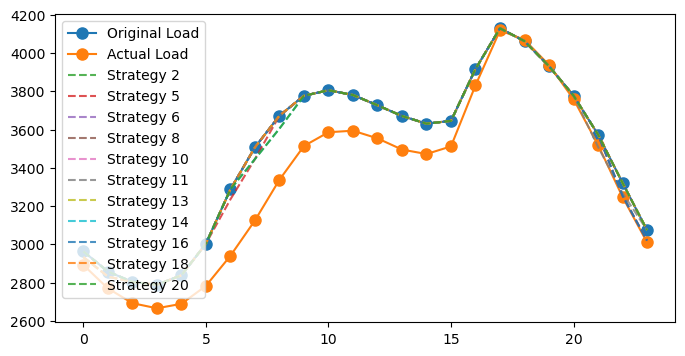

Found 0 relevant failed reflection cases for inquiry 0


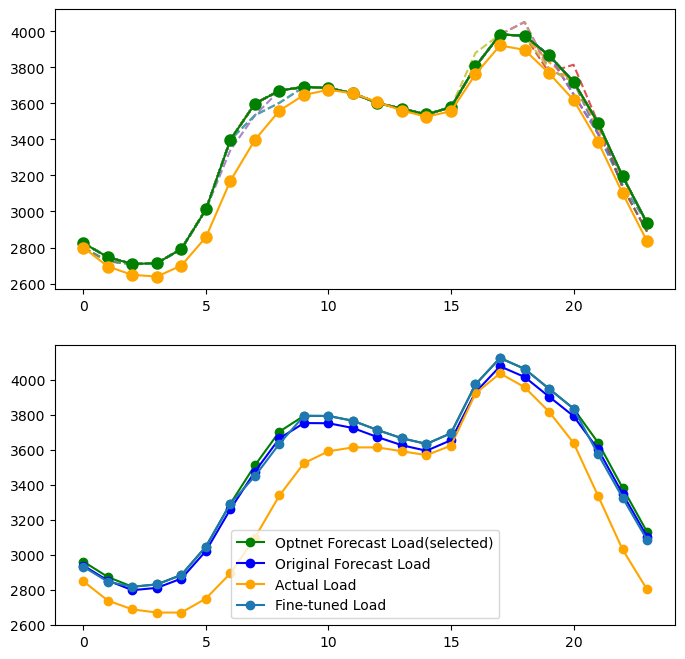

Original cost: 2634.5273003214147, Optnet cost: 2683.2298906861465, Fine-tuned cost: 2655.520638173612
The following samples (inquire_id) did not complete LLM fine-tuning; original forecast curves were used: []
The following samples (inquire_id) failed to find effective strategies on validation set; original forecast curves were used: []
Processing inquiry 2/29
Found 3 similar days for inquiry 1
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Found valid strategy strategy_6, cost 2547.19, original cost 2569.26, (reduction 22.08)
Strategy generation attempt #2 (Current valid strategies: 1/20)
Found valid strategy strategy_4, cost 2566.71, original cost 2569.26, (reduction 2.55)
Found valid strategy strategy_6, cost 2547.19, original cost 2569.26, (reduction 22.08)
Strategy generation attempt #3 (Current valid strategies: 3/20)
Give actual value
Found valid strategy strategy_6, cost 2547.19, original cost 2569.26, (redu

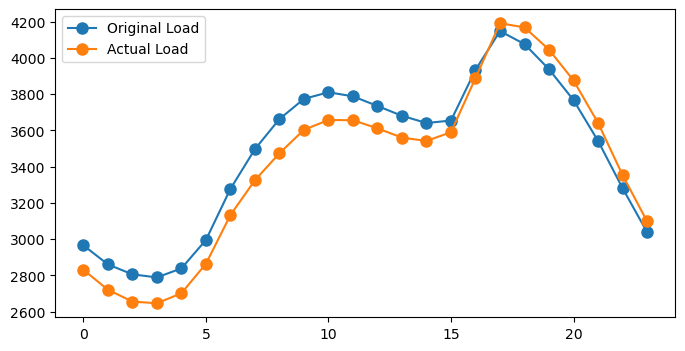

Inquiry 1: No valid strategy found, using original curve as fine-tuned result.
2718.066943702441
2704.5593756349745
2690.7047493787077


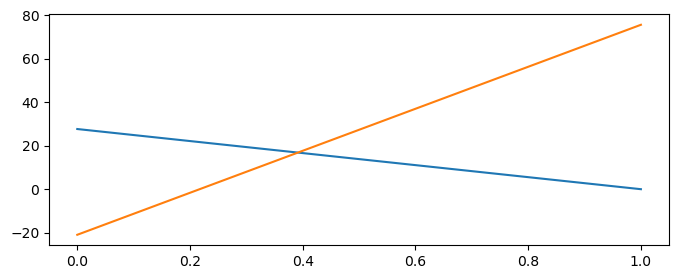

Processing inquiry 3/29
Found 3 similar days for inquiry 2
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Strategy generation attempt #2 (Current valid strategies: 0/20)
Strategy generation attempt #3 (Current valid strategies: 0/20)
Give actual value
Strategy generation attempt #4 (Current valid strategies: 0/20)
Give actual value
Found valid strategy strategy_7, cost 2543.73, original cost 2547.10, (reduction 3.37)
Strategy generation attempt #5 (Current valid strategies: 1/20)
Give actual value
Found valid strategy strategy_7, cost 2543.73, original cost 2547.10, (reduction 3.37)
Strategy generation attempt #6 (Current valid strategies: 2/20)
Give actual value
Found valid strategy strategy_6, cost 2544.88, original cost 2547.10, (reduction 2.22)
Found valid strategy strategy_7, cost 2543.73, original cost 2547.10, (reduction 3.37)
Strategy generation attempt #7 (Current valid strategies: 4/20)
Give actual value
Fo

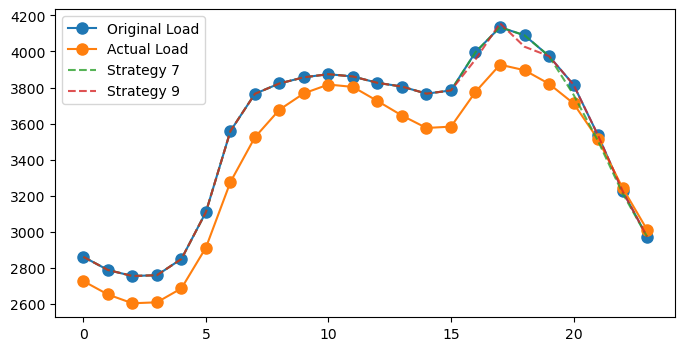

Found 1 relevant failed reflection cases for inquiry 2


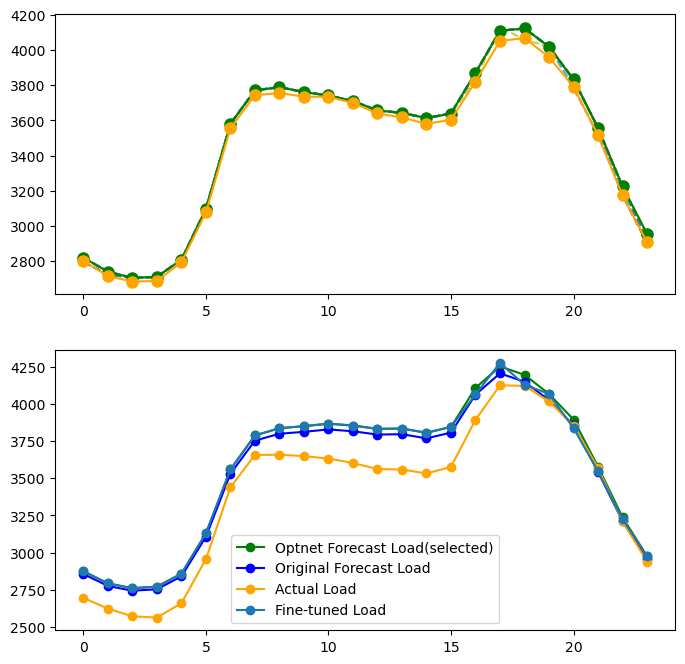

Original cost: 2642.0838102679863, Optnet cost: 2688.5819022194173, Fine-tuned cost: 2684.7911728896906
2692.739232557623
2699.2335511631222
2688.733557215702


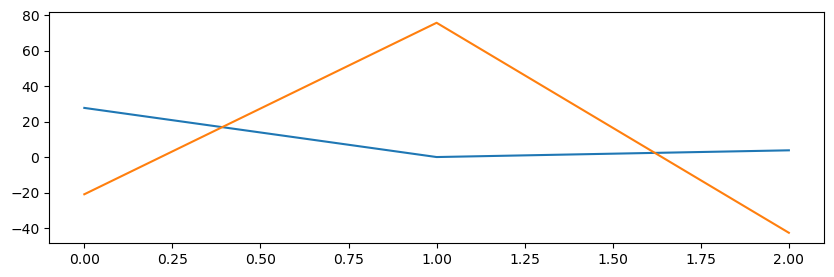

The following samples (inquire_id) did not complete LLM fine-tuning; original forecast curves were used: [1]
The following samples (inquire_id) failed to find effective strategies on validation set; original forecast curves were used: []
Processing inquiry 4/29
Found 3 similar days for inquiry 3
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Found valid strategy strategy_1, cost 2764.80, original cost 2783.16, (reduction 18.36)
Found valid strategy strategy_4, cost 2780.94, original cost 2783.16, (reduction 2.22)
Found valid strategy strategy_6, cost 2741.11, original cost 2783.16, (reduction 42.05)
Found valid strategy strategy_7, cost 2754.03, original cost 2783.16, (reduction 29.12)
Found valid strategy strategy_8, cost 2769.99, original cost 2783.16, (reduction 13.16)
Strategy generation attempt #2 (Current valid strategies: 5/20)
Found valid strategy strategy_1, cost 2763.82, original cost 2783.16, (reduction 19

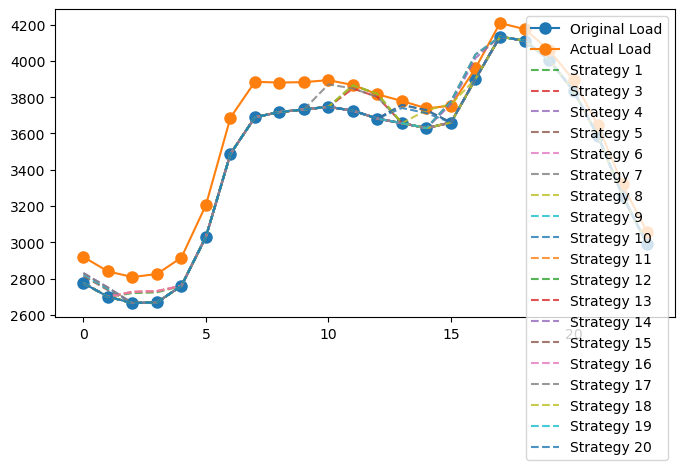

Found 1 relevant failed reflection cases for inquiry 3


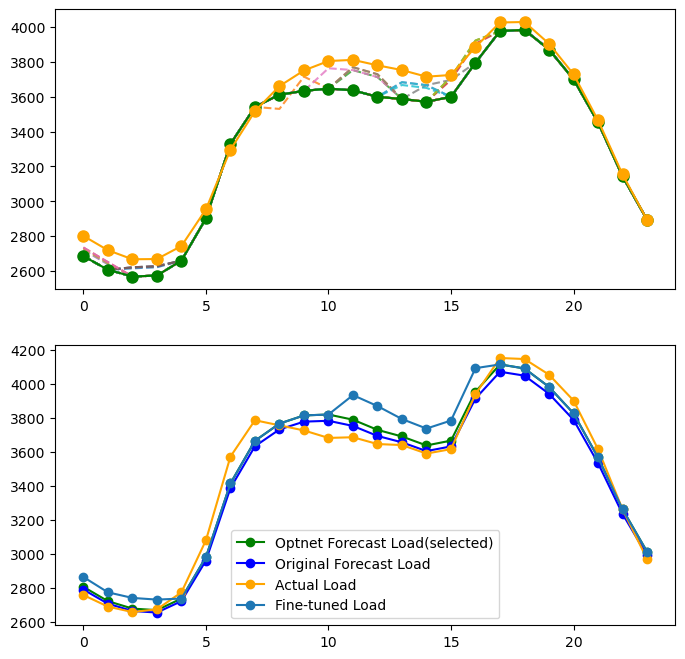

Original cost: 2701.675167438641, Optnet cost: 2651.3905727721785, Fine-tuned cost: 2700.5661370718603
Strategy generation attempt #1 (Current valid strategies: 0/5)
Found valid strategy strategy_1, cost 2667.20, original cost 2701.68, (reduction 34.48)
Found valid strategy strategy_2, cost 2689.60, original cost 2701.68, (reduction 12.07)
Strategy generation attempt #2 (Current valid strategies: 2/5)
Give actual value
Found valid strategy strategy_5, cost 2697.57, original cost 2701.68, (reduction 4.11)
Strategy generation attempt #3 (Current valid strategies: 3/5)
Give actual value
Found valid strategy strategy_4, cost 2671.91, original cost 2701.68, (reduction 29.77)
2694.9732162778773
2687.2728065653864
2691.6917021797417


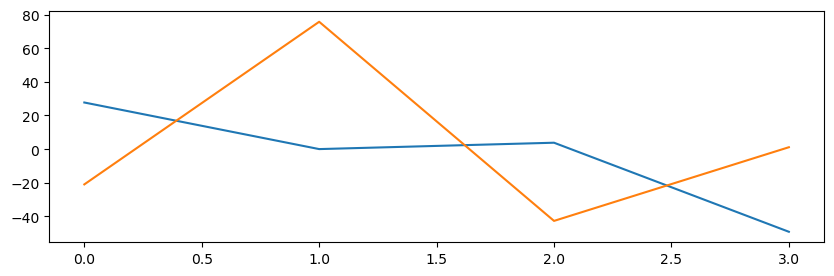

The following samples (inquire_id) did not complete LLM fine-tuning; original forecast curves were used: [1]
The following samples (inquire_id) failed to find effective strategies on validation set; original forecast curves were used: []
Processing inquiry 5/29
Found 3 similar days for inquiry 4
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Found valid strategy strategy_3, cost 2977.84, original cost 2996.73, (reduction 18.89)
Found valid strategy strategy_6, cost 2962.94, original cost 2996.73, (reduction 33.79)
Strategy generation attempt #2 (Current valid strategies: 2/20)
Found valid strategy strategy_2, cost 2976.99, original cost 2996.73, (reduction 19.75)
Found valid strategy strategy_4, cost 2953.99, original cost 2996.73, (reduction 42.75)
Found valid strategy strategy_6, cost 2962.94, original cost 2996.73, (reduction 33.79)
Found valid strategy strategy_7, cost 2965.63, original cost 2996.73, (reduction 3

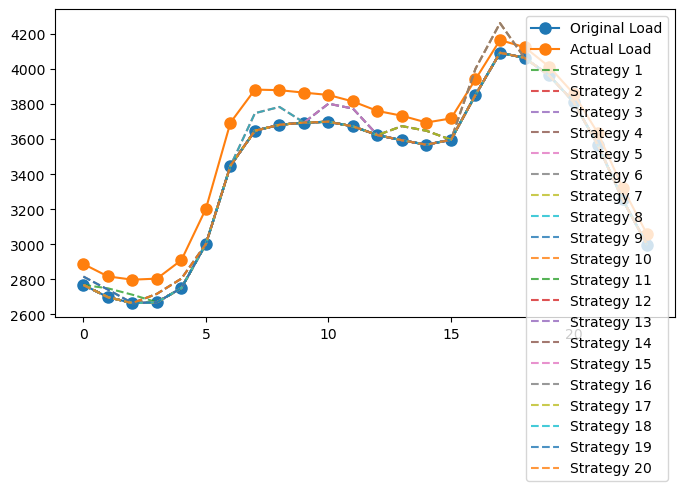

Found 1 relevant failed reflection cases for inquiry 4


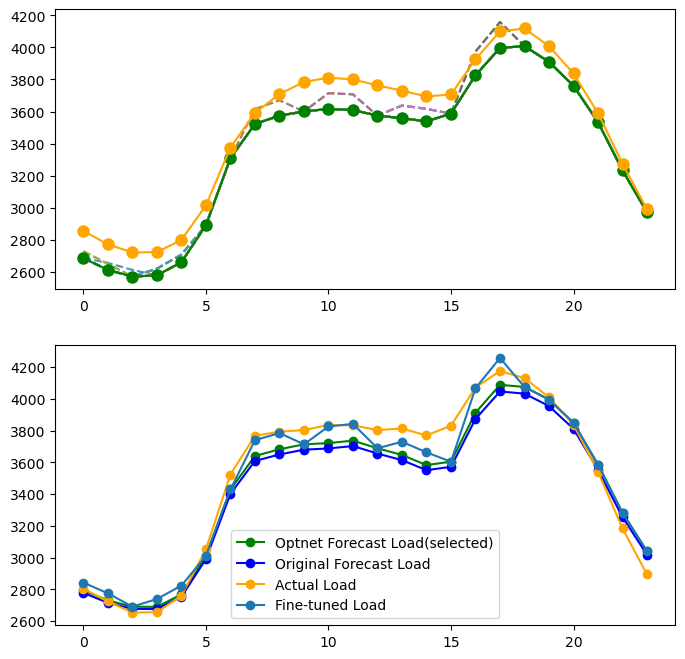

Original cost: 2925.1930823928265, Optnet cost: 2829.006024908226, Fine-tuned cost: 2690.7070816702217
2741.017189500867
2715.6194502339545
2691.4947780778375


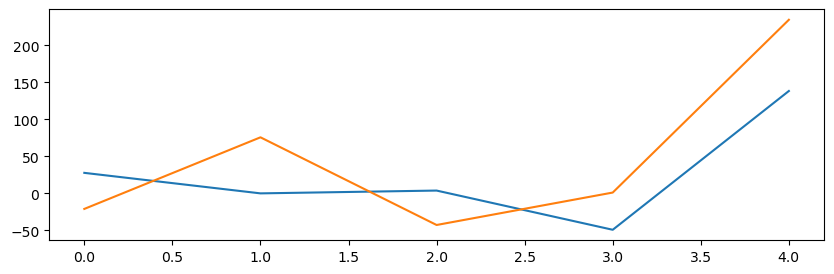

The following samples (inquire_id) did not complete LLM fine-tuning; original forecast curves were used: [1]
The following samples (inquire_id) failed to find effective strategies on validation set; original forecast curves were used: []
Processing inquiry 6/29
Found 3 similar days for inquiry 5
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Found valid strategy strategy_5, cost 2545.27, original cost 2547.10, (reduction 1.83)
Strategy generation attempt #2 (Current valid strategies: 1/20)
Found valid strategy strategy_5, cost 2545.27, original cost 2547.10, (reduction 1.83)
Found valid strategy strategy_6, cost 2545.78, original cost 2547.10, (reduction 1.32)
Strategy generation attempt #3 (Current valid strategies: 3/20)
Give actual value
Found valid strategy strategy_5, cost 2544.87, original cost 2547.10, (reduction 2.23)
Found valid strategy strategy_6, cost 2545.78, original cost 2547.10, (reduction 1.32)
Found

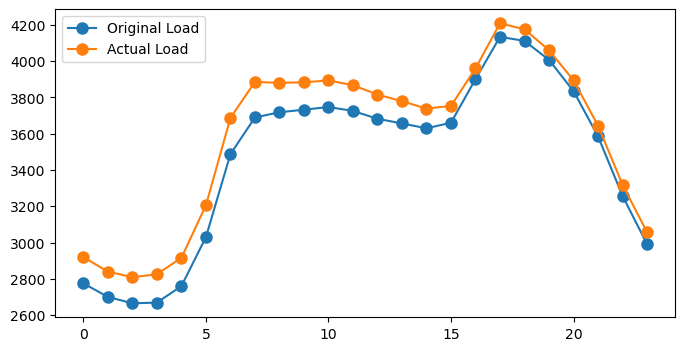

Inquiry 5: No valid strategy found, using original curve as fine-tuned result.
2710.9215450646316
2694.660997713749
2674.5571042503184


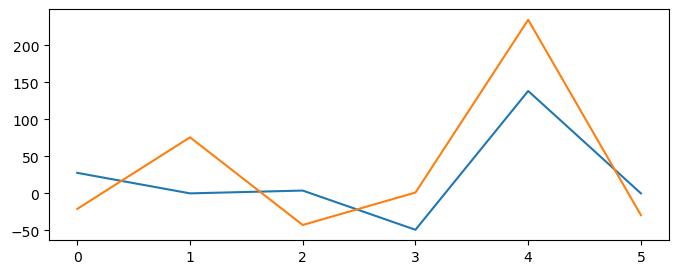

Processing inquiry 7/29
Found 3 similar days for inquiry 6
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Found valid strategy strategy_3, cost 2597.09, original cost 2600.26, (reduction 3.17)
Strategy generation attempt #2 (Current valid strategies: 1/20)
Found valid strategy strategy_3, cost 2597.09, original cost 2600.26, (reduction 3.17)
Found valid strategy strategy_7, cost 2586.57, original cost 2600.26, (reduction 13.69)
Strategy generation attempt #3 (Current valid strategies: 3/20)
Give actual value
Found valid strategy strategy_1, cost 2598.68, original cost 2600.26, (reduction 1.58)
Found valid strategy strategy_3, cost 2584.29, original cost 2600.26, (reduction 15.97)
Found valid strategy strategy_7, cost 2594.82, original cost 2600.26, (reduction 5.43)
Found valid strategy strategy_8, cost 2582.71, original cost 2600.26, (reduction 17.54)
Strategy generation attempt #4 (Current valid strategies: 7/20)
Gi

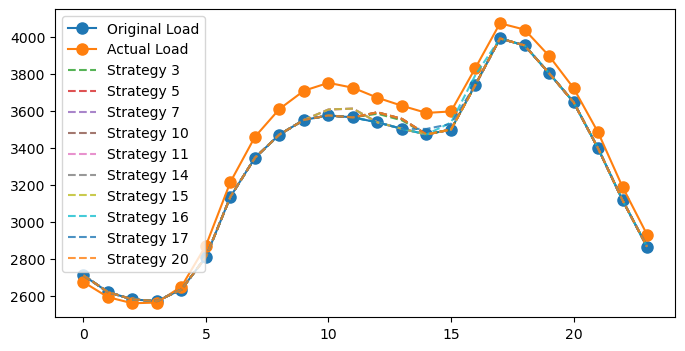

Found 1 relevant failed reflection cases for inquiry 6


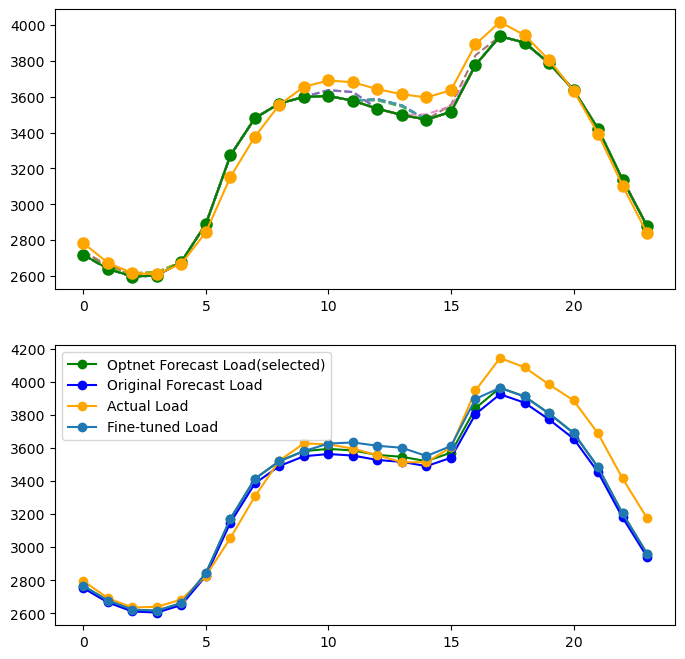

Original cost: 2846.988340009753, Optnet cost: 2761.79063128945, Fine-tuned cost: 2746.9341268847256
2730.3596586282206
2704.2509453674206
2684.8966789123765


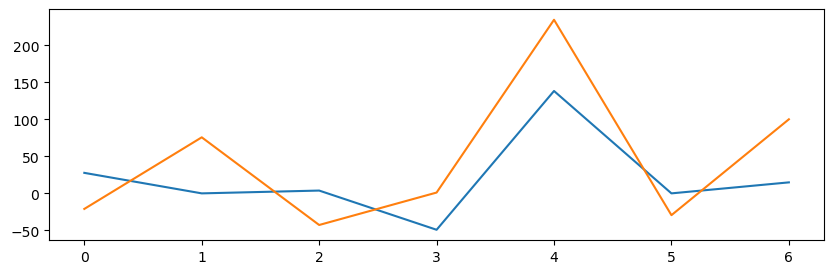

The following samples (inquire_id) did not complete LLM fine-tuning; original forecast curves were used: [1, 5]
The following samples (inquire_id) failed to find effective strategies on validation set; original forecast curves were used: []
Processing inquiry 8/29
Found 3 similar days for inquiry 7
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Found valid strategy strategy_2, cost 2986.30, original cost 2996.73, (reduction 10.43)
Found valid strategy strategy_5, cost 2969.96, original cost 2996.73, (reduction 26.78)
Found valid strategy strategy_7, cost 2978.38, original cost 2996.73, (reduction 18.35)
Found valid strategy strategy_8, cost 2970.74, original cost 2996.73, (reduction 25.99)
Strategy generation attempt #2 (Current valid strategies: 4/20)
Found valid strategy strategy_2, cost 2984.99, original cost 2996.73, (reduction 11.74)
Found valid strategy strategy_5, cost 2979.69, original cost 2996.73, (reductio

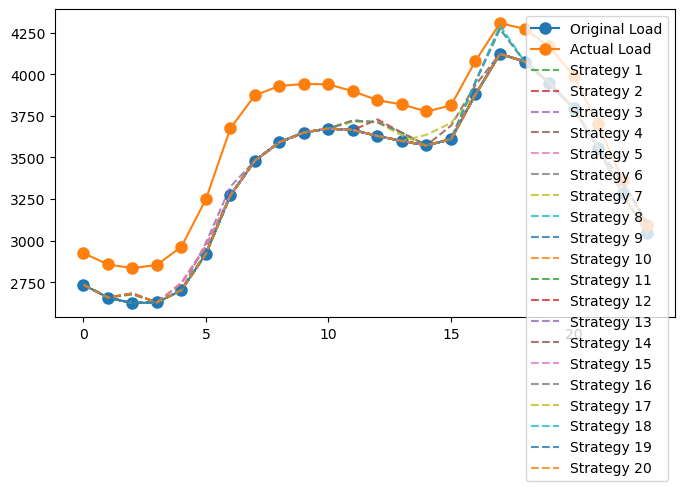

Found 1 relevant failed reflection cases for inquiry 7


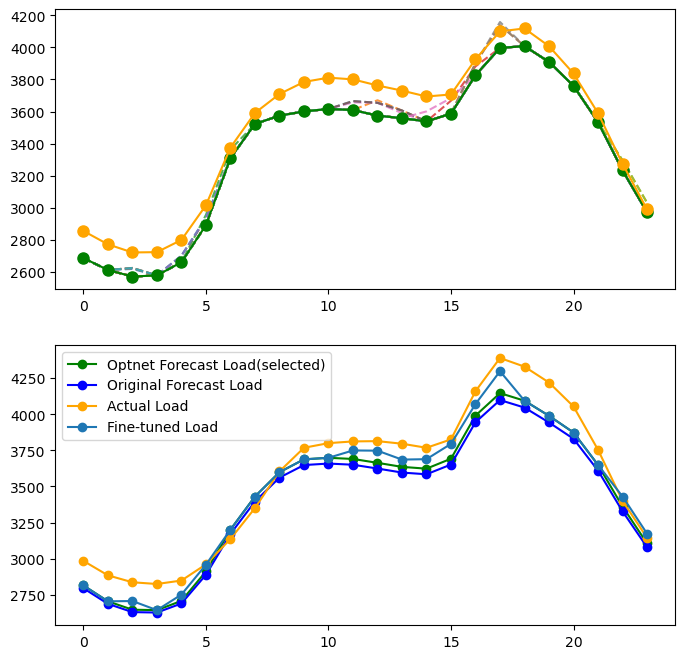

Original cost: 3247.5740080321257, Optnet cost: 3098.3850154330503, Fine-tuned cost: 2954.578932472542
2795.011452303708
2753.517704125624
2718.606960607397


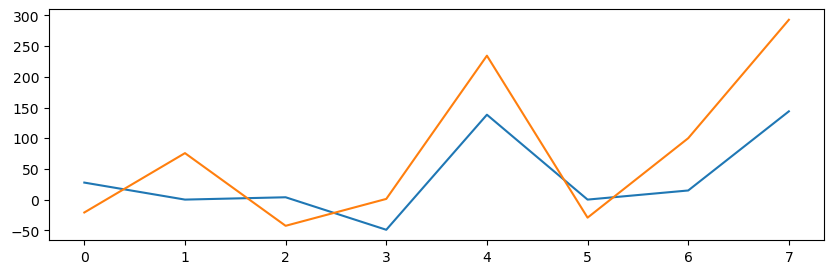

The following samples (inquire_id) did not complete LLM fine-tuning; original forecast curves were used: [1, 5]
The following samples (inquire_id) failed to find effective strategies on validation set; original forecast curves were used: []
Processing inquiry 9/29
Found 3 similar days for inquiry 8
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Strategy generation attempt #2 (Current valid strategies: 0/20)
Found valid strategy strategy_7, cost 2610.82, original cost 2622.76, (reduction 11.95)
Strategy generation attempt #3 (Current valid strategies: 1/20)
Give actual value
Found valid strategy strategy_1, cost 2618.70, original cost 2622.76, (reduction 4.06)
Found valid strategy strategy_5, cost 2604.95, original cost 2622.76, (reduction 17.81)
Found valid strategy strategy_6, cost 2612.66, original cost 2622.76, (reduction 10.10)
Found valid strategy strategy_7, cost 2610.82, original cost 2622.76, (reduction 11.95

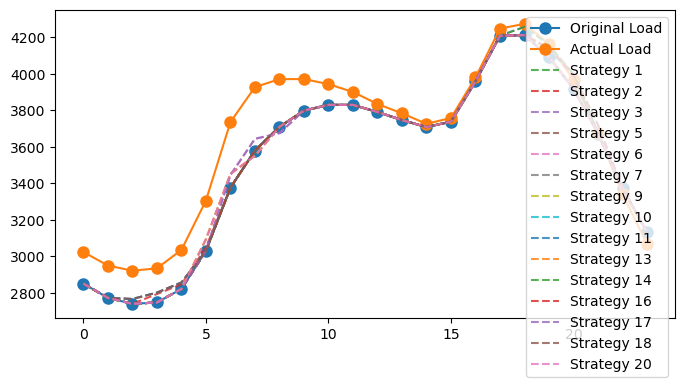

Found 1 relevant failed reflection cases for inquiry 8


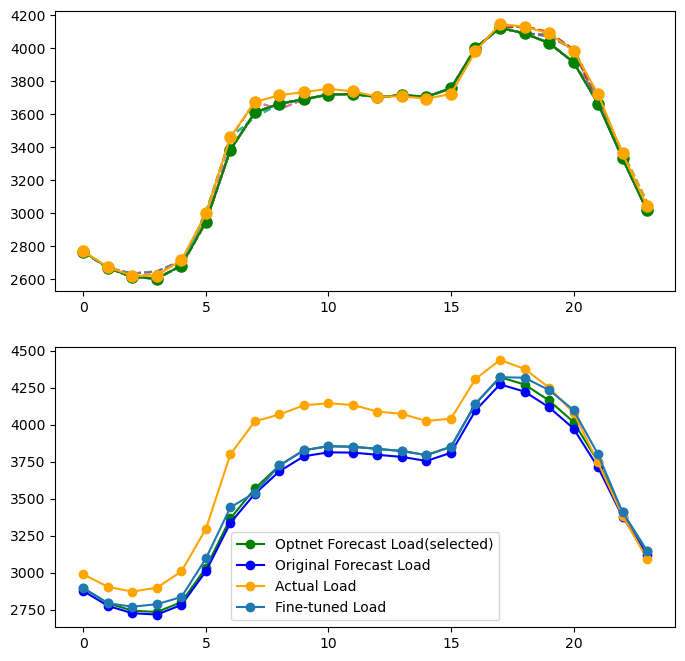

Original cost: 3694.3591574271395, Optnet cost: 3541.633501179437, Fine-tuned cost: 3472.5486302911513
2894.938975095201
2841.086126020492
2802.3782572389255


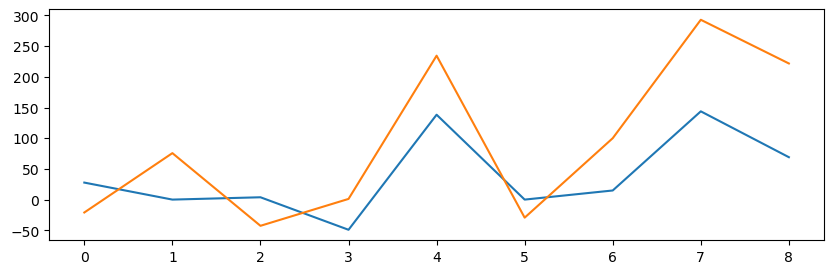

The following samples (inquire_id) did not complete LLM fine-tuning; original forecast curves were used: [1, 5]
The following samples (inquire_id) failed to find effective strategies on validation set; original forecast curves were used: []
Processing inquiry 10/29
Found 3 similar days for inquiry 9
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Found valid strategy strategy_1, cost 2663.62, original cost 2677.47, (reduction 13.85)
Found valid strategy strategy_7, cost 2668.35, original cost 2677.47, (reduction 9.13)
Found valid strategy strategy_8, cost 2672.52, original cost 2677.47, (reduction 4.96)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Found valid strategy strategy_1, cost 2663.62, original cost 2677.47, (reduction 13.85)
Found valid strategy strategy_5, cost 2667.95, original cost 2677.47, (reduction 9.52)
Found valid strategy strategy_6, cost 2668.35, original cost 2677.47, (reduction 

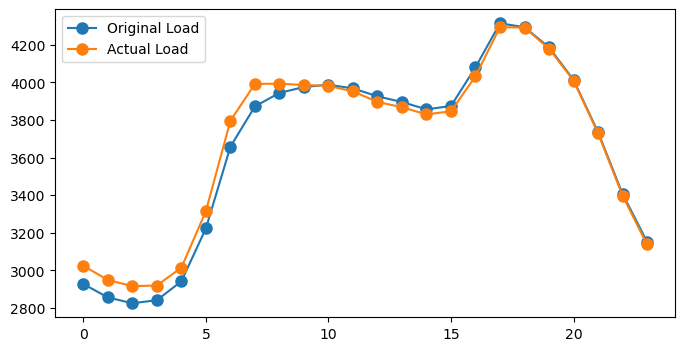

Inquiry 9: No valid strategy found, using original curve as fine-tuned result.
2896.386905297343
2841.0812312542084
2806.2441493507986


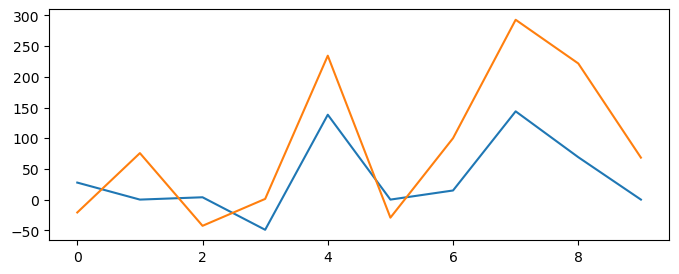

Processing inquiry 11/29
Found 3 similar days for inquiry 10
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Found valid strategy strategy_1, cost 2668.59, original cost 2677.47, (reduction 8.88)
Found valid strategy strategy_5, cost 2667.19, original cost 2677.47, (reduction 10.28)
Found valid strategy strategy_6, cost 2675.60, original cost 2677.47, (reduction 1.87)
Found valid strategy strategy_7, cost 2672.64, original cost 2677.47, (reduction 4.83)
Strategy generation attempt #2 (Current valid strategies: 4/20)
Found valid strategy strategy_1, cost 2668.59, original cost 2677.47, (reduction 8.88)
Found valid strategy strategy_5, cost 2671.12, original cost 2677.47, (reduction 6.35)
Found valid strategy strategy_7, cost 2672.64, original cost 2677.47, (reduction 4.83)
Strategy generation attempt #3 (Current valid strategies: 7/20)
Give actual value
Found valid strategy strategy_1, cost 2668.59, original cost 2677.

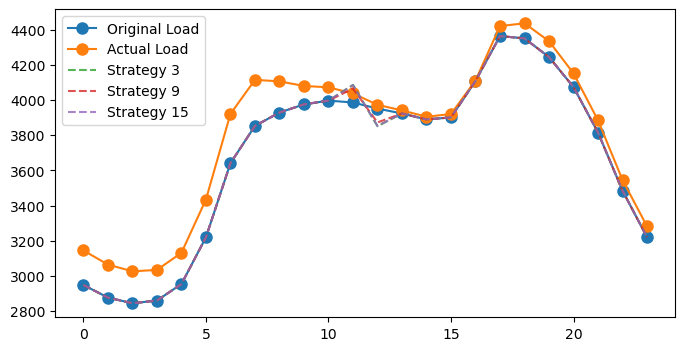

Found 1 relevant failed reflection cases for inquiry 10


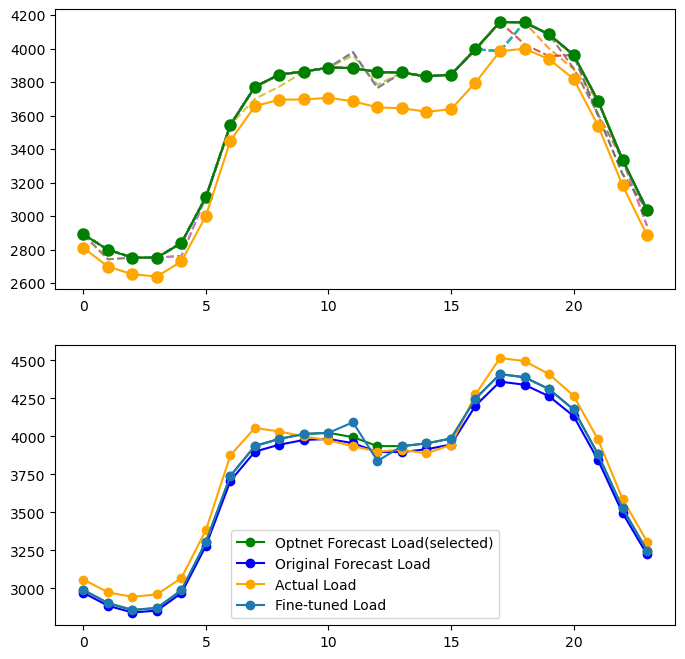

Original cost: 3062.280412496956, Optnet cost: 2962.9659414405905, Fine-tuned cost: 2970.4199917870947
Strategy generation attempt #1 (Current valid strategies: 0/5)
Found valid strategy strategy_4, cost 3055.07, original cost 3062.28, (reduction 7.21)
Strategy generation attempt #2 (Current valid strategies: 1/5)
Give actual value
Found valid strategy strategy_6, cost 3050.17, original cost 3062.28, (reduction 12.11)
Strategy generation attempt #3 (Current valid strategies: 2/5)
Give actual value
Found valid strategy strategy_3, cost 3053.95, original cost 3062.28, (reduction 8.33)
Found valid strategy strategy_6, cost 3053.49, original cost 3062.28, (reduction 8.79)
Found valid strategy strategy_8, cost 3056.84, original cost 3062.28, (reduction 5.44)
2911.468133224581
2852.16165945297
2821.169225935916


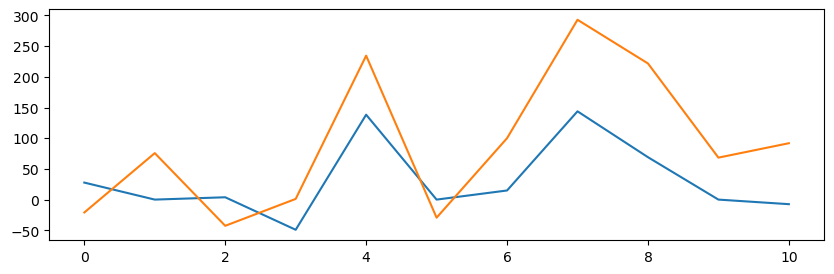

The following samples (inquire_id) did not complete LLM fine-tuning; original forecast curves were used: [1, 5, 9]
The following samples (inquire_id) failed to find effective strategies on validation set; original forecast curves were used: []
Processing inquiry 12/29
Found 3 similar days for inquiry 11
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Found valid strategy strategy_1, cost 2668.59, original cost 2677.47, (reduction 8.88)
Found valid strategy strategy_7, cost 2674.61, original cost 2677.47, (reduction 2.86)
Strategy generation attempt #2 (Current valid strategies: 2/20)
Found valid strategy strategy_1, cost 2668.59, original cost 2677.47, (reduction 8.88)
Found valid strategy strategy_5, cost 2665.85, original cost 2677.47, (reduction 11.62)
Found valid strategy strategy_7, cost 2676.26, original cost 2677.47, (reduction 1.21)
Strategy generation attempt #3 (Current valid strategies: 5/20)
Give actual va

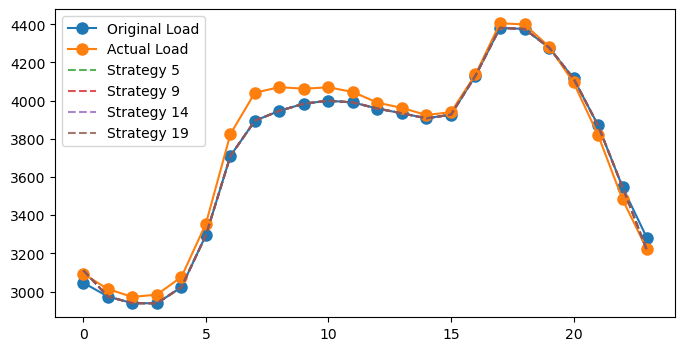

Found 1 relevant failed reflection cases for inquiry 11


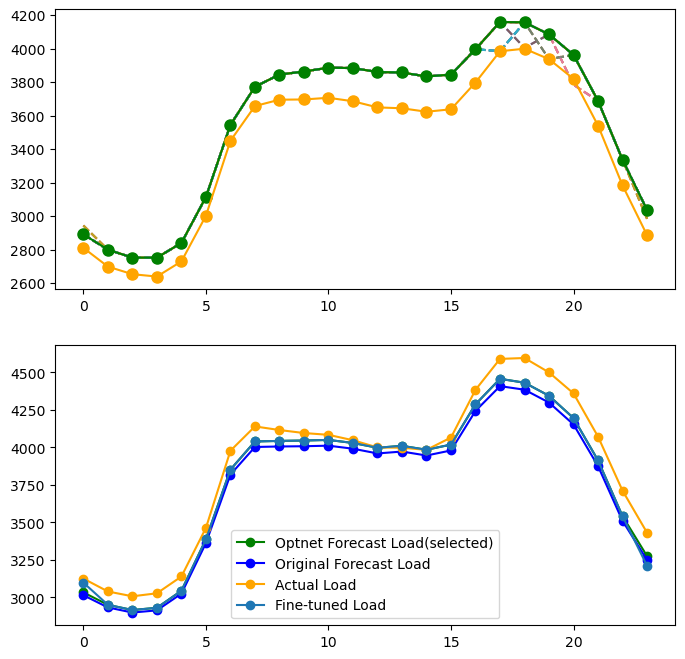

Original cost: 3307.3354521264546, Optnet cost: 3161.1806971664255, Fine-tuned cost: 3163.2119755327494
Strategy generation attempt #1 (Current valid strategies: 0/5)
Found valid strategy strategy_3, cost 3296.32, original cost 3307.34, (reduction 11.02)
Strategy generation attempt #2 (Current valid strategies: 1/5)
Give actual value
Found valid strategy strategy_3, cost 3296.37, original cost 3307.34, (reduction 10.97)
Found valid strategy strategy_7, cost 3296.54, original cost 3307.34, (reduction 10.80)
Strategy generation attempt #3 (Current valid strategies: 3/5)
Give actual value
Found valid strategy strategy_3, cost 3291.37, original cost 3307.34, (reduction 15.96)
Found valid strategy strategy_5, cost 3294.95, original cost 3307.34, (reduction 12.39)
2944.4570764664036
2877.9132459290918
2849.672788402319


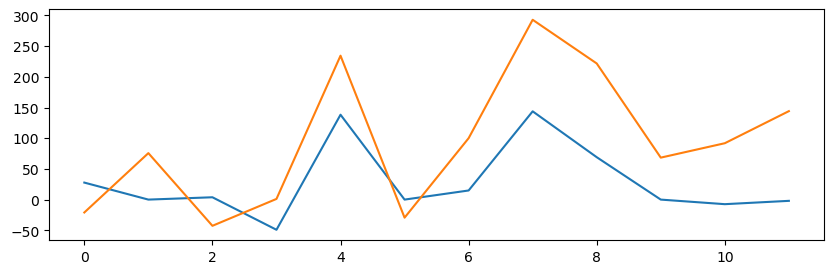

The following samples (inquire_id) did not complete LLM fine-tuning; original forecast curves were used: [1, 5, 9]
The following samples (inquire_id) failed to find effective strategies on validation set; original forecast curves were used: []
Processing inquiry 13/29
Found 3 similar days for inquiry 12
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Found valid strategy strategy_1, cost 2668.59, original cost 2677.47, (reduction 8.88)
Strategy generation attempt #2 (Current valid strategies: 1/20)
Found valid strategy strategy_1, cost 2668.59, original cost 2677.47, (reduction 8.88)
Found valid strategy strategy_6, cost 2674.01, original cost 2677.47, (reduction 3.46)
Strategy generation attempt #3 (Current valid strategies: 3/20)
Give actual value
Found valid strategy strategy_1, cost 2668.59, original cost 2677.47, (reduction 8.88)
Found valid strategy strategy_5, cost 2671.12, original cost 2677.47, (reduction 6.3

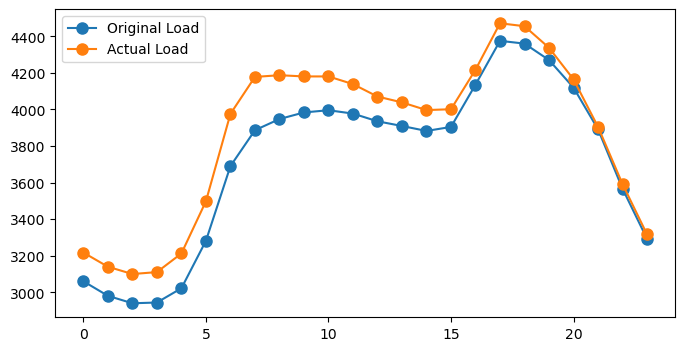

Inquiry 12: No valid strategy found, using original curve as fine-tuned result.
2987.2158742996826
2912.995574690746
2886.927460050648


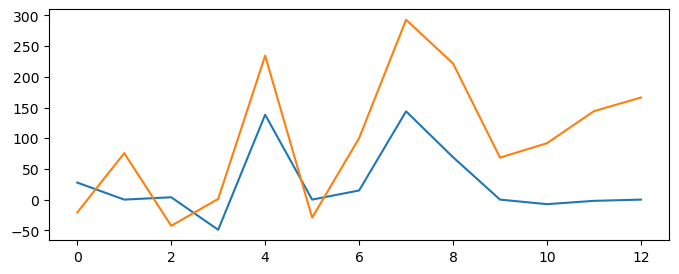

Processing inquiry 14/29
Found 3 similar days for inquiry 13
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Found valid strategy strategy_1, cost 2668.59, original cost 2677.47, (reduction 8.88)
Found valid strategy strategy_5, cost 2668.83, original cost 2677.47, (reduction 8.64)
Found valid strategy strategy_6, cost 2674.62, original cost 2677.47, (reduction 2.85)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Found valid strategy strategy_1, cost 2668.59, original cost 2677.47, (reduction 8.88)
Found valid strategy strategy_5, cost 2670.23, original cost 2677.47, (reduction 7.24)
Found valid strategy strategy_6, cost 2670.82, original cost 2677.47, (reduction 6.65)
Found valid strategy strategy_8, cost 2666.20, original cost 2677.47, (reduction 11.27)
Strategy generation attempt #3 (Current valid strategies: 7/20)
Give actual value
Found valid strategy strategy_1, cost 2670.30, original cost 2677.

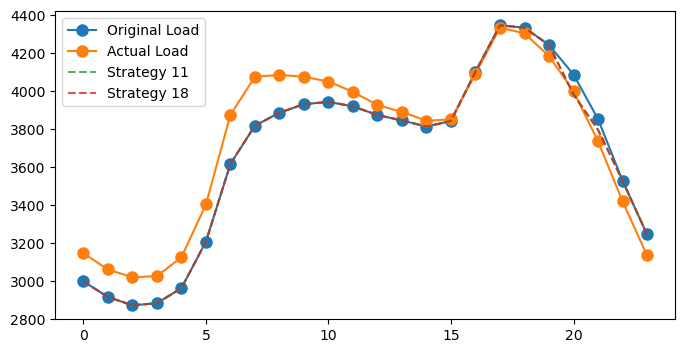

Found 1 relevant failed reflection cases for inquiry 13


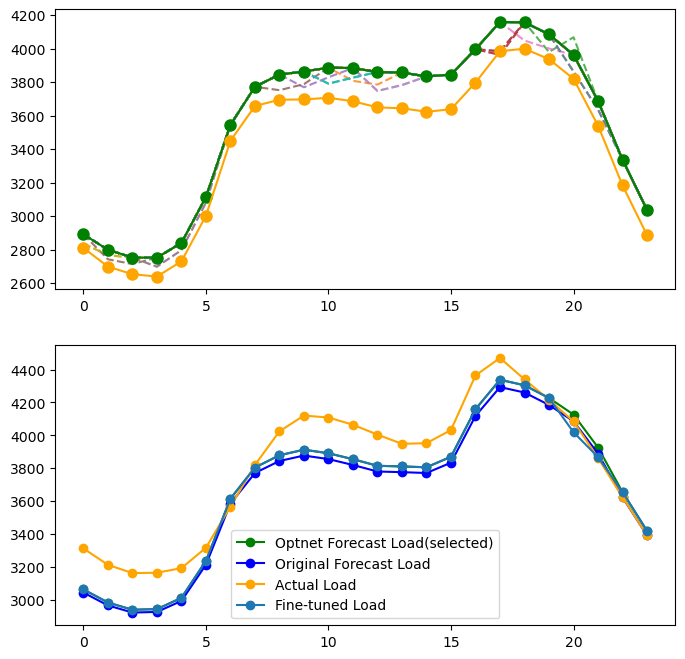

Original cost: 3419.0610370639943, Optnet cost: 3305.152711839269, Fine-tuned cost: 3310.9219851734083
Strategy generation attempt #1 (Current valid strategies: 0/5)
Found valid strategy strategy_3, cost 3393.60, original cost 3419.06, (reduction 25.46)
Strategy generation attempt #2 (Current valid strategies: 1/5)
Give actual value
Found valid strategy strategy_6, cost 3406.66, original cost 3419.06, (reduction 12.40)
Found valid strategy strategy_8, cost 3407.21, original cost 3419.06, (reduction 11.85)
Strategy generation attempt #3 (Current valid strategies: 3/5)
Give actual value
Found valid strategy strategy_2, cost 3391.04, original cost 3419.06, (reduction 28.02)
Found valid strategy strategy_8, cost 3408.67, original cost 3419.06, (reduction 10.39)
3018.061957354276
2941.006798772783
2917.2127832737024


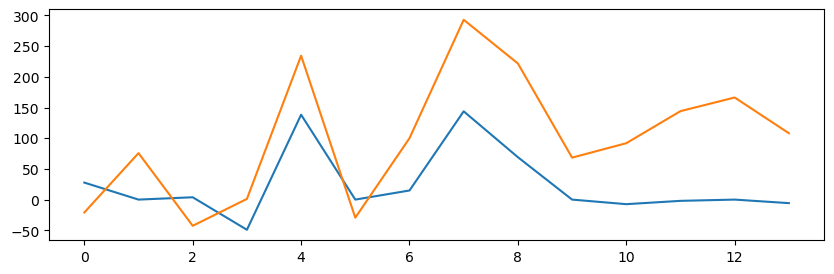

The following samples (inquire_id) did not complete LLM fine-tuning; original forecast curves were used: [1, 5, 9, 12]
The following samples (inquire_id) failed to find effective strategies on validation set; original forecast curves were used: []
Processing inquiry 15/29
Found 3 similar days for inquiry 14
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Found valid strategy strategy_1, cost 2668.59, original cost 2677.47, (reduction 8.88)
Found valid strategy strategy_5, cost 2668.61, original cost 2677.47, (reduction 8.86)
Found valid strategy strategy_7, cost 2674.27, original cost 2677.47, (reduction 3.20)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Found valid strategy strategy_1, cost 2668.59, original cost 2677.47, (reduction 8.88)
Found valid strategy strategy_5, cost 2668.61, original cost 2677.47, (reduction 8.86)
Found valid strategy strategy_6, cost 2667.31, original cost 2677.47, (redu

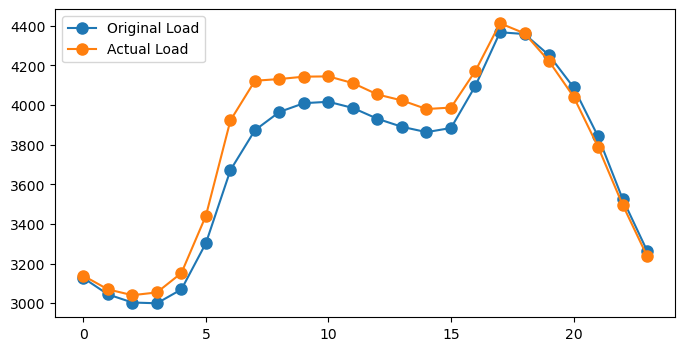

Inquiry 14: No valid strategy found, using original curve as fine-tuned result.
3014.4009206165583
2940.3938174393393
2918.1860696401973


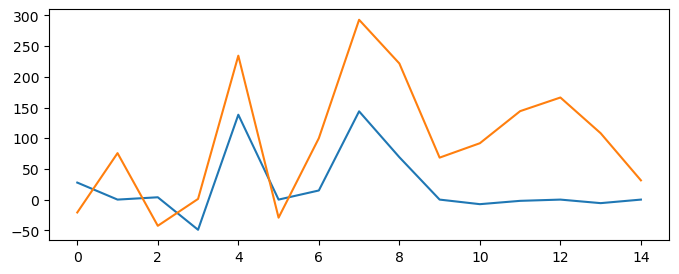

Processing inquiry 16/29
Found 3 similar days for inquiry 15
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Found valid strategy strategy_1, cost 2668.59, original cost 2677.47, (reduction 8.88)
Found valid strategy strategy_5, cost 2672.64, original cost 2677.47, (reduction 4.83)
Found valid strategy strategy_6, cost 2674.62, original cost 2677.47, (reduction 2.85)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Found valid strategy strategy_1, cost 2668.59, original cost 2677.47, (reduction 8.88)
Found valid strategy strategy_4, cost 2671.47, original cost 2677.47, (reduction 6.00)
Found valid strategy strategy_5, cost 2668.55, original cost 2677.47, (reduction 8.92)
Found valid strategy strategy_8, cost 2676.30, original cost 2677.47, (reduction 1.18)
Strategy generation attempt #3 (Current valid strategies: 7/20)
Give actual value
Found valid strategy strategy_1, cost 2668.59, original cost 2677.4

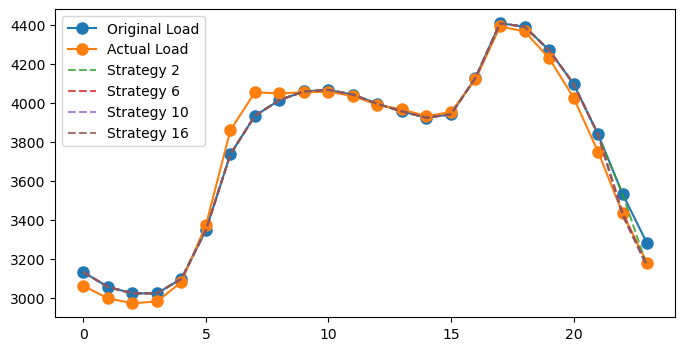

Found 1 relevant failed reflection cases for inquiry 15


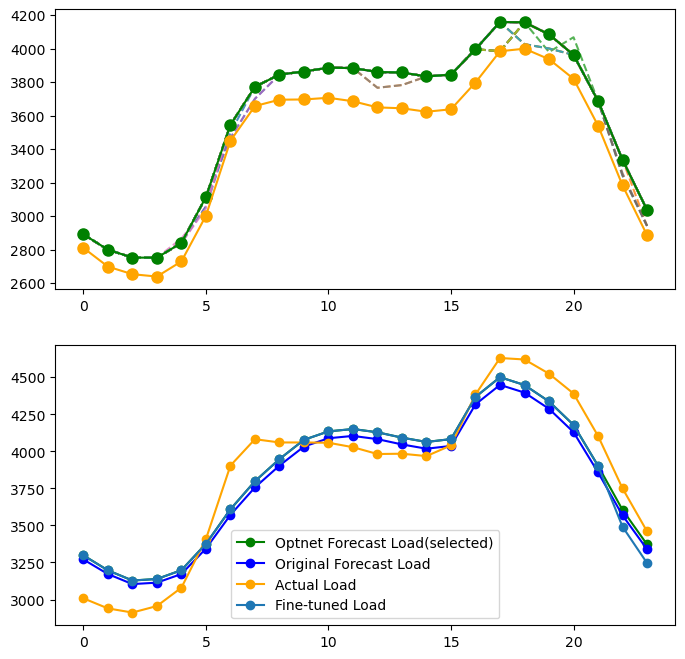

Original cost: 3311.373267953664, Optnet cost: 3227.1972062843224, Fine-tuned cost: 3279.41535188501
Strategy generation attempt #1 (Current valid strategies: 0/5)
Found valid strategy strategy_6, cost 3300.80, original cost 3311.37, (reduction 10.58)
Strategy generation attempt #2 (Current valid strategies: 1/5)
Give actual value
Found valid strategy strategy_6, cost 3299.30, original cost 3311.37, (reduction 12.07)
Found valid strategy strategy_8, cost 3309.01, original cost 3311.37, (reduction 2.36)
Strategy generation attempt #3 (Current valid strategies: 3/5)
Give actual value
Found valid strategy strategy_2, cost 3307.50, original cost 3311.37, (reduction 3.88)
Found valid strategy strategy_3, cost 3302.60, original cost 3311.37, (reduction 8.78)
3032.9616923251283
2958.319029242151
2940.7628997804977


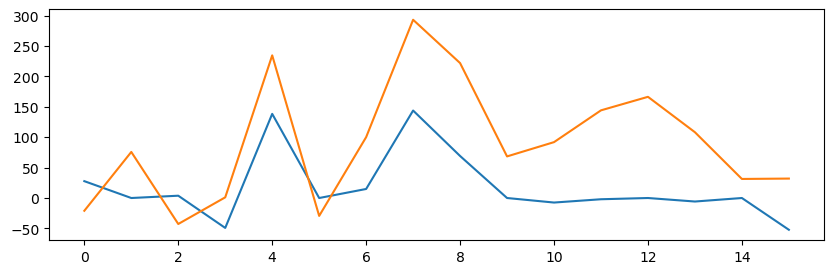

The following samples (inquire_id) did not complete LLM fine-tuning; original forecast curves were used: [1, 5, 9, 12, 14]
The following samples (inquire_id) failed to find effective strategies on validation set; original forecast curves were used: []
Processing inquiry 17/29
Found 3 similar days for inquiry 16
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Found valid strategy strategy_1, cost 2663.36, original cost 2677.47, (reduction 14.11)
Found valid strategy strategy_4, cost 2671.47, original cost 2677.47, (reduction 6.00)
Found valid strategy strategy_6, cost 2669.90, original cost 2677.47, (reduction 7.57)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Found valid strategy strategy_1, cost 2663.36, original cost 2677.47, (reduction 14.11)
Found valid strategy strategy_2, cost 2670.46, original cost 2677.47, (reduction 7.01)
Found valid strategy strategy_5, cost 2670.77, original cost 2677.47,

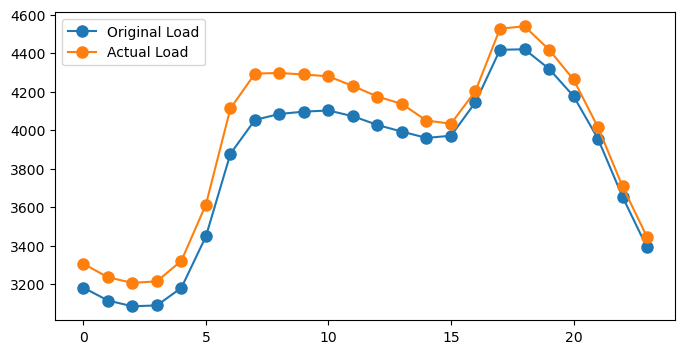

Inquiry 16: No valid strategy found, using original curve as fine-tuned result.
3074.3203887851614
2993.876189360805
2977.352773396896


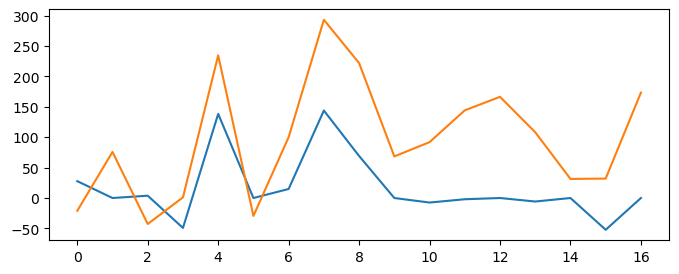

Processing inquiry 18/29
Found 3 similar days for inquiry 17
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Found valid strategy strategy_1, cost 2668.59, original cost 2677.47, (reduction 8.88)
Found valid strategy strategy_6, cost 2671.76, original cost 2677.47, (reduction 5.71)
Strategy generation attempt #2 (Current valid strategies: 2/20)
Found valid strategy strategy_1, cost 2668.59, original cost 2677.47, (reduction 8.88)
Found valid strategy strategy_3, cost 2670.84, original cost 2677.47, (reduction 6.63)
Found valid strategy strategy_5, cost 2669.76, original cost 2677.47, (reduction 7.71)
Found valid strategy strategy_6, cost 2671.76, original cost 2677.47, (reduction 5.71)
Found valid strategy strategy_8, cost 2673.37, original cost 2677.47, (reduction 4.10)
Strategy generation attempt #3 (Current valid strategies: 7/20)
Give actual value
Found valid strategy strategy_1, cost 2668.59, original cost 2677.4

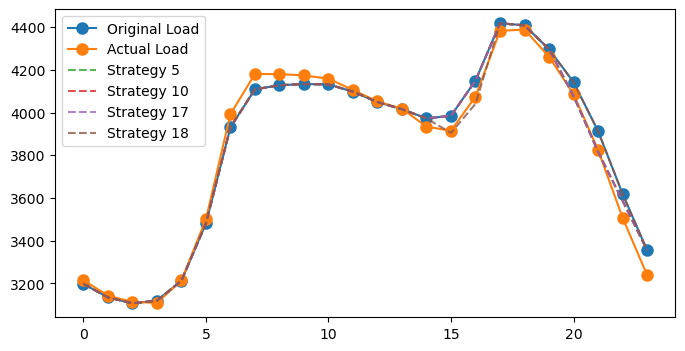

Found 1 relevant failed reflection cases for inquiry 17


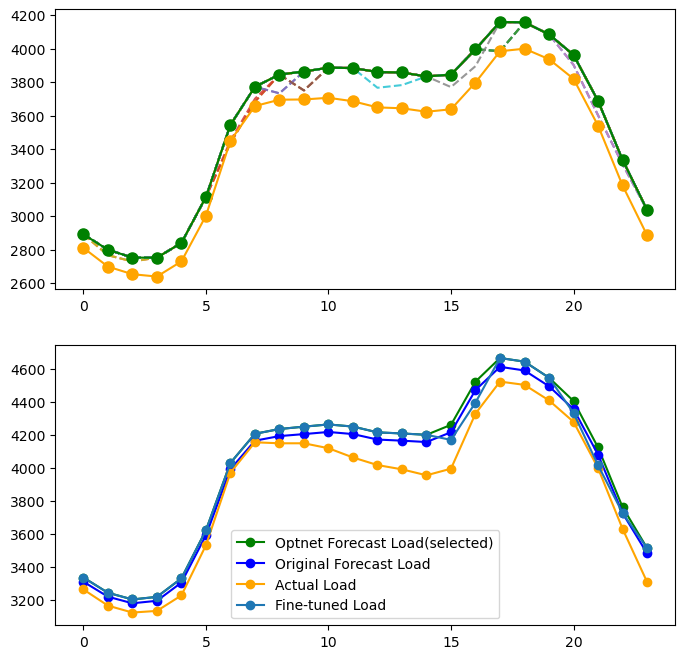

Original cost: 2947.299633076948, Optnet cost: 3000.7956192745196, Fine-tuned cost: 2977.104607857926
3067.2636801347053
2994.260602133789
2977.3389864225082


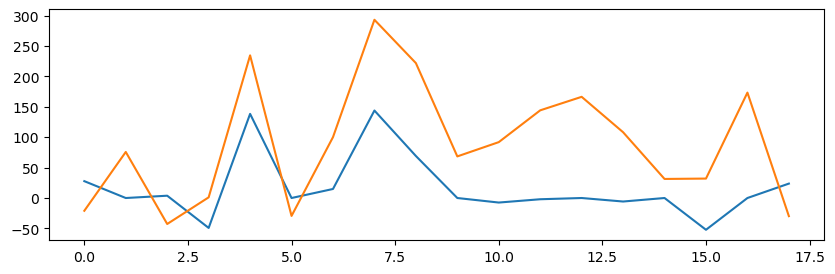

The following samples (inquire_id) did not complete LLM fine-tuning; original forecast curves were used: [1, 5, 9, 12, 14, 16]
The following samples (inquire_id) failed to find effective strategies on validation set; original forecast curves were used: []
Processing inquiry 19/29
Found 3 similar days for inquiry 18
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Found valid strategy strategy_3, cost 2674.62, original cost 2677.47, (reduction 2.85)
Found valid strategy strategy_7, cost 2676.26, original cost 2677.47, (reduction 1.21)
Found valid strategy strategy_8, cost 2669.75, original cost 2677.47, (reduction 7.72)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Found valid strategy strategy_1, cost 2670.33, original cost 2677.47, (reduction 7.14)
Found valid strategy strategy_5, cost 2667.30, original cost 2677.47, (reduction 10.17)
Found valid strategy strategy_7, cost 2670.33, original cost 2677.

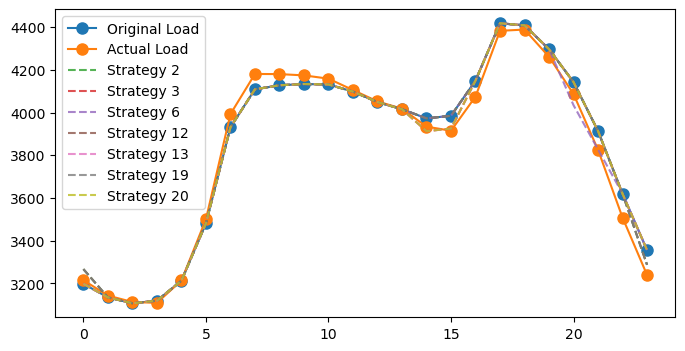

Found 1 relevant failed reflection cases for inquiry 18


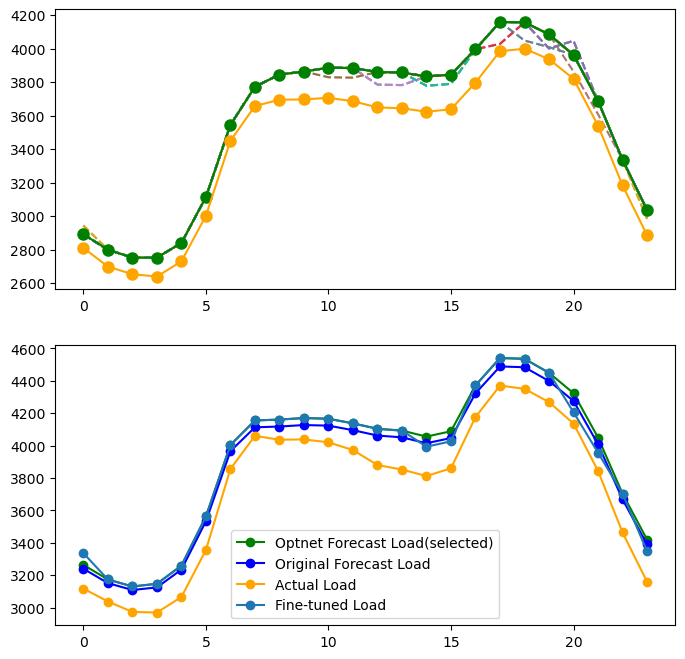

Original cost: 2902.8766078505278, Optnet cost: 2964.825443914473, Fine-tuned cost: 2942.517115359554
3058.6117289618537
2992.7113832801406
2975.5062563665633


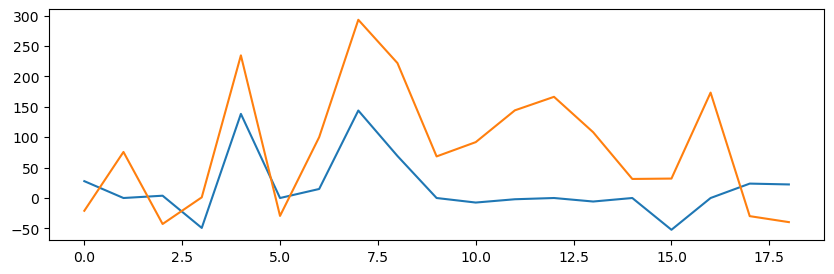

The following samples (inquire_id) did not complete LLM fine-tuning; original forecast curves were used: [1, 5, 9, 12, 14, 16]
The following samples (inquire_id) failed to find effective strategies on validation set; original forecast curves were used: []
Processing inquiry 20/29
Found 3 similar days for inquiry 19
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Found valid strategy strategy_1, cost 2668.59, original cost 2677.47, (reduction 8.88)
Found valid strategy strategy_6, cost 2670.08, original cost 2677.47, (reduction 7.39)
Strategy generation attempt #2 (Current valid strategies: 2/20)
Found valid strategy strategy_1, cost 2668.59, original cost 2677.47, (reduction 8.88)
Found valid strategy strategy_5, cost 2667.08, original cost 2677.47, (reduction 10.40)
Found valid strategy strategy_6, cost 2669.03, original cost 2677.47, (reduction 8.44)
Found valid strategy strategy_7, cost 2674.62, original cost 2677.

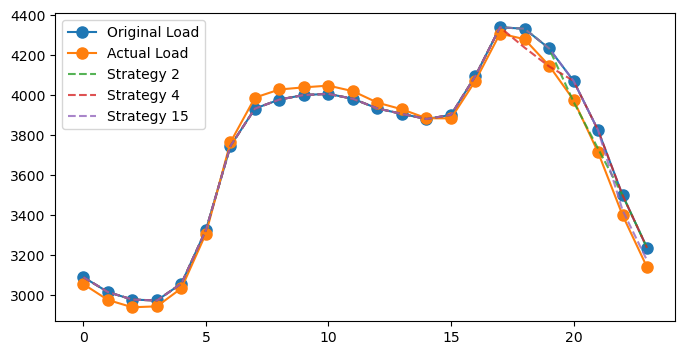

Found 1 relevant failed reflection cases for inquiry 19


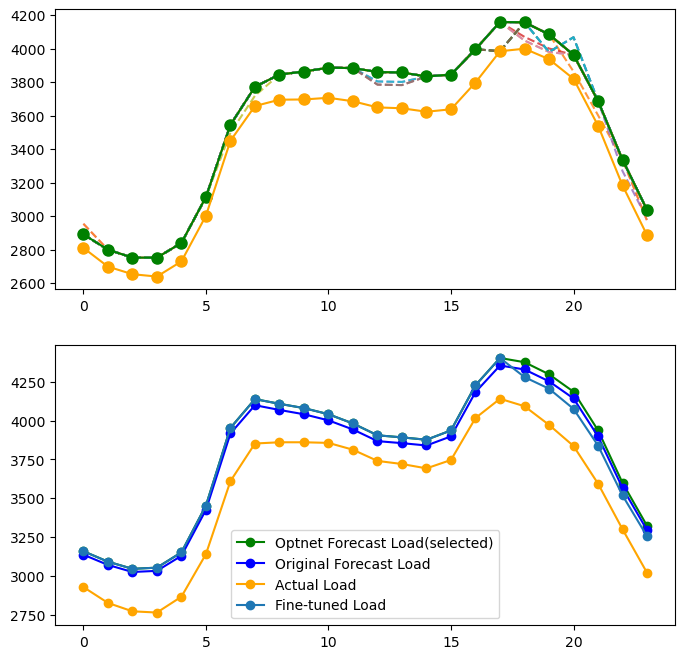

Original cost: 2896.3353479957345, Optnet cost: 2963.01187855347, Fine-tuned cost: 2918.3981050594684
3050.497909913548
2991.226408043807
2972.6508488012087


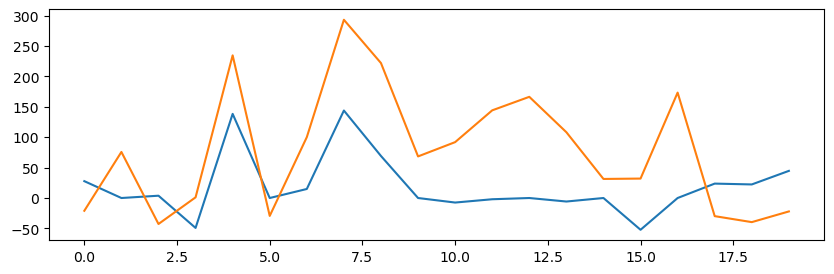

The following samples (inquire_id) did not complete LLM fine-tuning; original forecast curves were used: [1, 5, 9, 12, 14, 16]
The following samples (inquire_id) failed to find effective strategies on validation set; original forecast curves were used: []
Processing inquiry 21/29
Found 3 similar days for inquiry 20
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Found valid strategy strategy_2, cost 2552.96, original cost 2556.61, (reduction 3.65)
Found valid strategy strategy_4, cost 2554.86, original cost 2556.61, (reduction 1.76)
Strategy generation attempt #2 (Current valid strategies: 2/20)
Found valid strategy strategy_2, cost 2552.96, original cost 2556.61, (reduction 3.65)
Found valid strategy strategy_4, cost 2554.86, original cost 2556.61, (reduction 1.76)
Strategy generation attempt #3 (Current valid strategies: 4/20)
Give actual value
Found valid strategy strategy_2, cost 2553.31, original cost 2556.61, (r

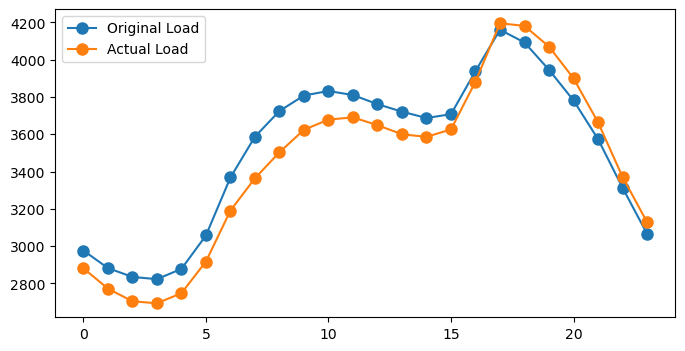

Inquiry 20: No valid strategy found, using original curve as fine-tuned result.
3034.7360265759617
2981.239723478752
2963.548714676277


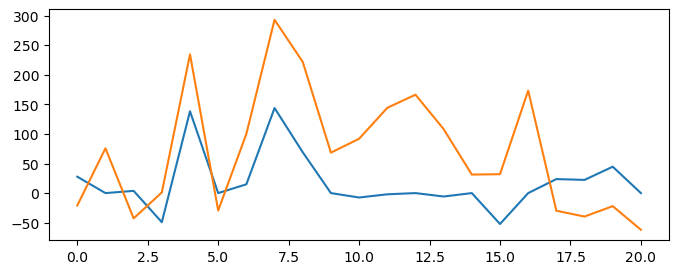

Processing inquiry 22/29
Found 3 similar days for inquiry 21
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Found valid strategy strategy_5, cost 2555.13, original cost 2556.61, (reduction 1.48)
Strategy generation attempt #2 (Current valid strategies: 1/20)
Found valid strategy strategy_5, cost 2552.23, original cost 2556.61, (reduction 4.38)
Strategy generation attempt #3 (Current valid strategies: 2/20)
Give actual value
Found valid strategy strategy_5, cost 2548.18, original cost 2556.61, (reduction 8.44)
Found valid strategy strategy_7, cost 2553.49, original cost 2556.61, (reduction 3.12)
Found valid strategy strategy_8, cost 2550.28, original cost 2556.61, (reduction 6.34)
Strategy generation attempt #4 (Current valid strategies: 5/20)
Give actual value
Found valid strategy strategy_3, cost 2552.68, original cost 2556.61, (reduction 3.94)
Found valid strategy strategy_5, cost 2548.18, original cost 2556.61, (r

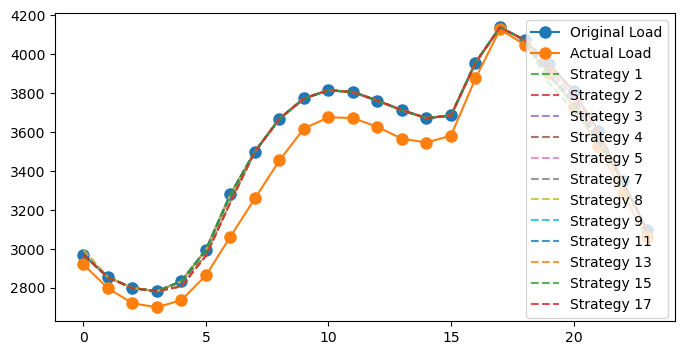

Found 1 relevant failed reflection cases for inquiry 21


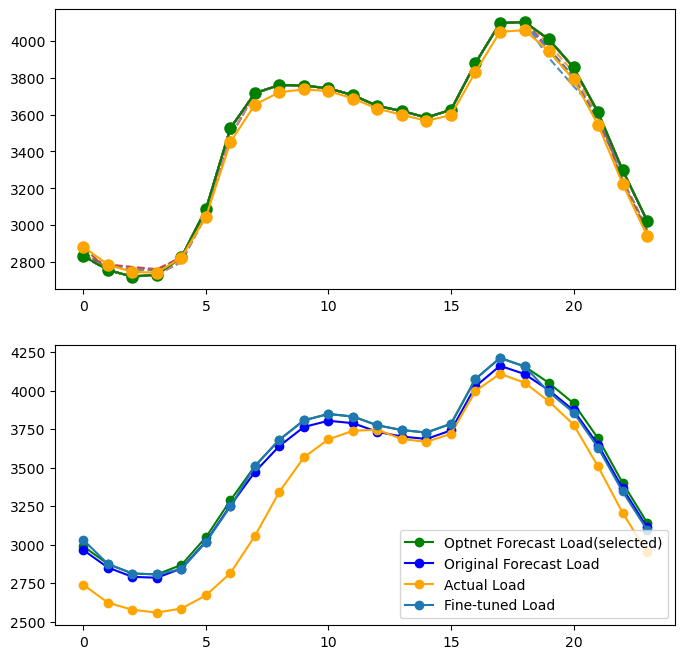

Original cost: 2666.427304837402, Optnet cost: 2718.438455375408, Fine-tuned cost: 2694.340121573493
3017.994721042391
2969.294211292236
2951.3119604443323


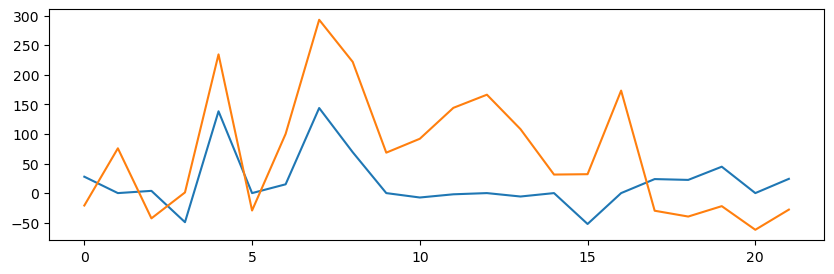

The following samples (inquire_id) did not complete LLM fine-tuning; original forecast curves were used: [1, 5, 9, 12, 14, 16, 20]
The following samples (inquire_id) failed to find effective strategies on validation set; original forecast curves were used: []
Processing inquiry 23/29
Found 3 similar days for inquiry 22
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Strategy generation attempt #2 (Current valid strategies: 0/20)
Strategy generation attempt #3 (Current valid strategies: 0/20)
Give actual value
Found valid strategy strategy_4, cost 2590.84, original cost 2597.84, (reduction 7.00)
Found valid strategy strategy_7, cost 2594.93, original cost 2597.84, (reduction 2.91)
Strategy generation attempt #4 (Current valid strategies: 2/20)
Give actual value
Found valid strategy strategy_4, cost 2592.28, original cost 2597.84, (reduction 5.56)
Found valid strategy strategy_6, cost 2593.56, original cost 2597.84, (re

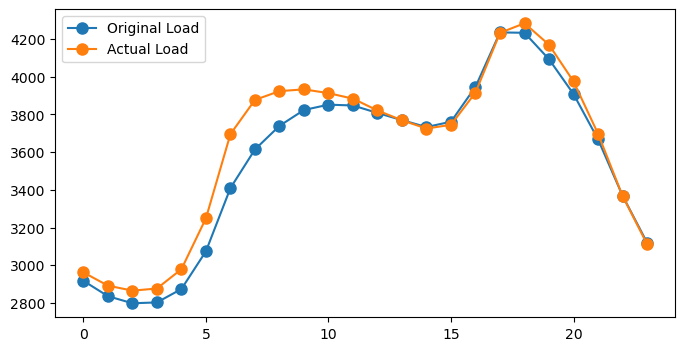

Inquiry 22: No valid strategy found, using original curve as fine-tuned result.
3004.2000479092994
2959.1560858673715
2941.9556720128544


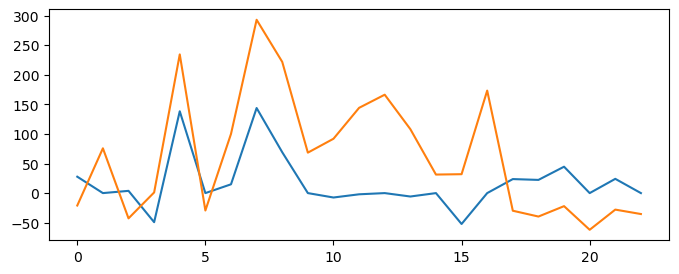

Processing inquiry 24/29
Found 3 similar days for inquiry 23
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Found valid strategy strategy_1, cost 2668.59, original cost 2677.47, (reduction 8.88)
Found valid strategy strategy_5, cost 2669.28, original cost 2677.47, (reduction 8.19)
Strategy generation attempt #2 (Current valid strategies: 2/20)
Found valid strategy strategy_1, cost 2668.59, original cost 2677.47, (reduction 8.88)
Found valid strategy strategy_5, cost 2669.28, original cost 2677.47, (reduction 8.19)
Found valid strategy strategy_7, cost 2674.62, original cost 2677.47, (reduction 2.85)
Strategy generation attempt #3 (Current valid strategies: 5/20)
Give actual value
Found valid strategy strategy_1, cost 2668.59, original cost 2677.47, (reduction 8.88)
Found valid strategy strategy_5, cost 2674.62, original cost 2677.47, (reduction 2.85)
Found valid strategy strategy_6, cost 2669.28, original cost 2677.4

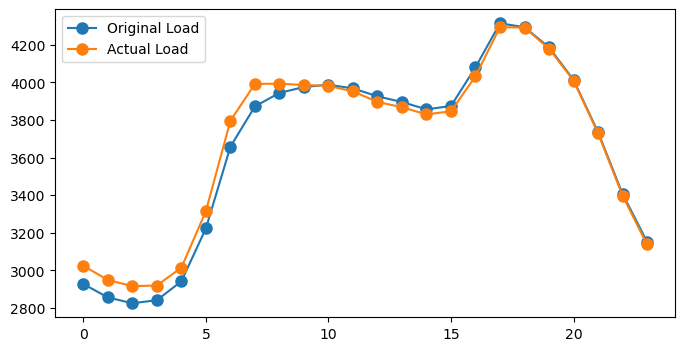

Inquiry 23: No valid strategy found, using original curve as fine-tuned result.
2997.4483431418557
2957.0097767602238
2940.526046816313


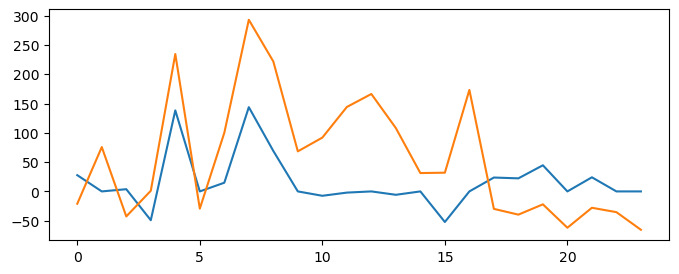

Processing inquiry 25/29
Found 3 similar days for inquiry 24
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Strategy generation attempt #2 (Current valid strategies: 0/20)
Strategy generation attempt #3 (Current valid strategies: 0/20)
Give actual value
Strategy generation attempt #4 (Current valid strategies: 0/20)
Give actual value
Found valid strategy strategy_6, cost 2625.54, original cost 2629.43, (reduction 3.89)
Strategy generation attempt #5 (Current valid strategies: 1/20)
Give actual value
Found valid strategy strategy_6, cost 2625.54, original cost 2629.43, (reduction 3.89)
Strategy generation attempt #6 (Current valid strategies: 2/20)
Give actual value
Found valid strategy strategy_6, cost 2625.54, original cost 2629.43, (reduction 3.89)
Found valid strategy strategy_7, cost 2622.84, original cost 2629.43, (reduction 6.59)
Strategy generation attempt #7 (Current valid strategies: 4/20)
Give actual value


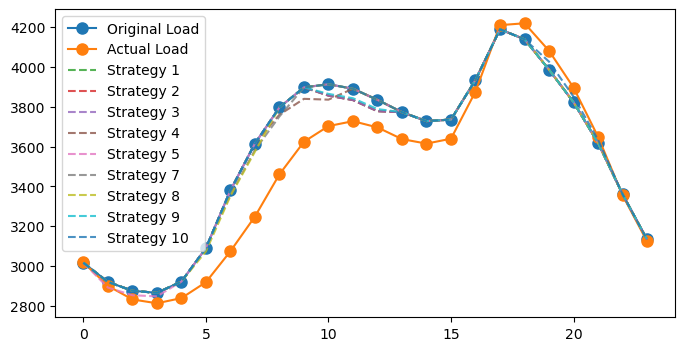

Found 1 relevant failed reflection cases for inquiry 24


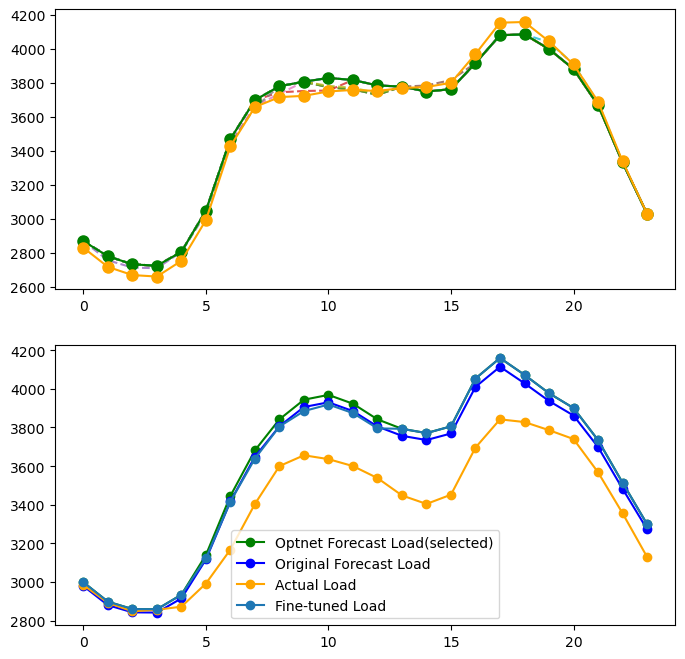

Original cost: 2721.3969195319137, Optnet cost: 2774.786802295648, Fine-tuned cost: 2747.730352253455
2986.406286197458
2949.720857781641
2932.8142190337985


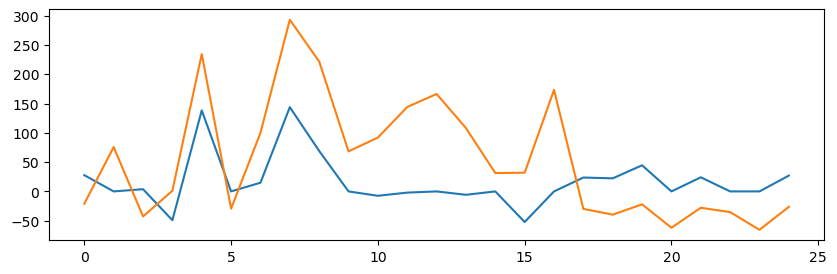

The following samples (inquire_id) did not complete LLM fine-tuning; original forecast curves were used: [1, 5, 9, 12, 14, 16, 20, 22, 23]
The following samples (inquire_id) failed to find effective strategies on validation set; original forecast curves were used: []
Processing inquiry 26/29
Found 3 similar days for inquiry 25
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Found valid strategy strategy_2, cost 2555.35, original cost 2556.61, (reduction 1.27)
Found valid strategy strategy_5, cost 2552.41, original cost 2556.61, (reduction 4.21)
Found valid strategy strategy_8, cost 2549.58, original cost 2556.61, (reduction 7.04)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Found valid strategy strategy_6, cost 2550.94, original cost 2556.61, (reduction 5.67)
Found valid strategy strategy_7, cost 2554.23, original cost 2556.61, (reduction 2.38)
Strategy generation attempt #3 (Current valid strategie

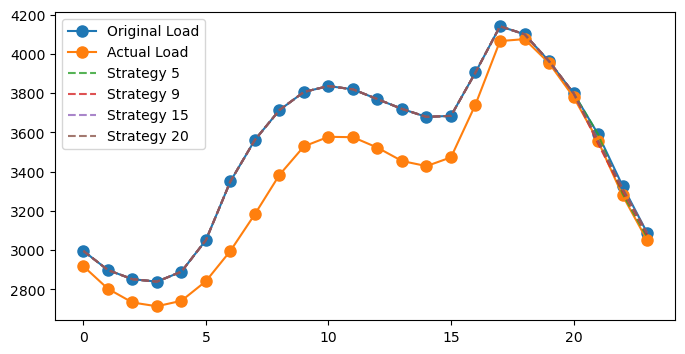

Found 1 relevant failed reflection cases for inquiry 25


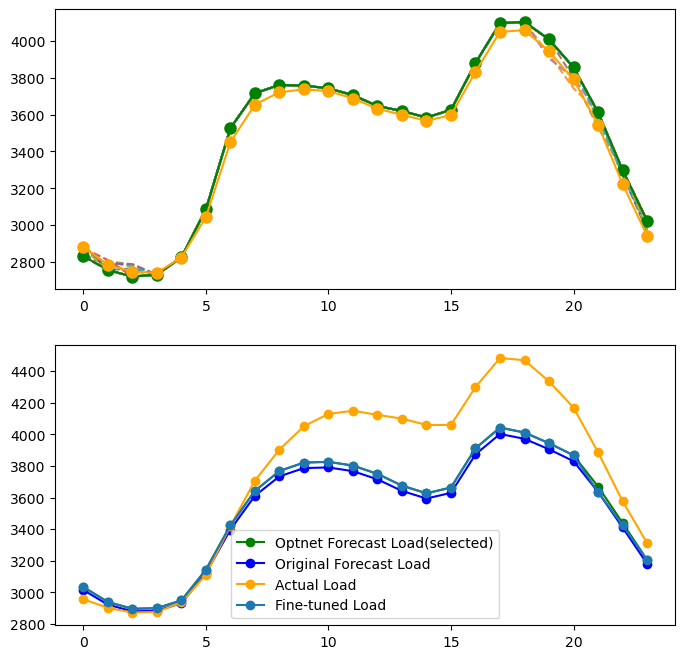

Original cost: 3860.899469687093, Optnet cost: 3736.284268218905, Fine-tuned cost: 3746.8445748622617
Strategy generation attempt #1 (Current valid strategies: 0/5)
Strategy generation attempt #2 (Current valid strategies: 0/5)
Give actual value
Found valid strategy strategy_4, cost 3840.15, original cost 3860.90, (reduction 20.75)
Strategy generation attempt #3 (Current valid strategies: 1/5)
Give actual value
Found valid strategy strategy_4, cost 3840.15, original cost 3860.90, (reduction 20.75)
Found valid strategy strategy_6, cost 3851.65, original cost 3860.90, (reduction 9.25)
3020.0406394085976
2979.9732966446127
2964.1230788733546


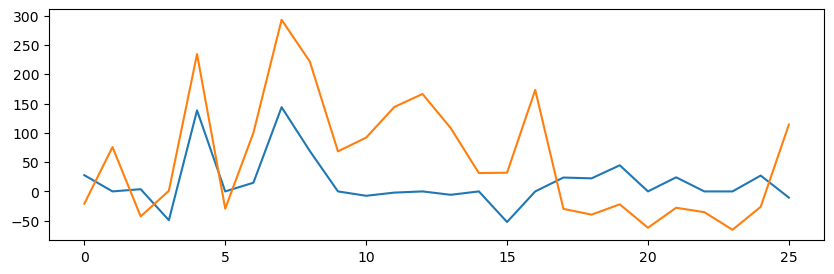

The following samples (inquire_id) did not complete LLM fine-tuning; original forecast curves were used: [1, 5, 9, 12, 14, 16, 20, 22, 23]
The following samples (inquire_id) failed to find effective strategies on validation set; original forecast curves were used: []
Processing inquiry 27/29
Found 3 similar days for inquiry 26
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Found valid strategy strategy_7, cost 2594.92, original cost 2597.84, (reduction 2.92)
Found valid strategy strategy_8, cost 2592.55, original cost 2597.84, (reduction 5.29)
Strategy generation attempt #2 (Current valid strategies: 2/20)
Found valid strategy strategy_5, cost 2594.72, original cost 2597.84, (reduction 3.12)
Found valid strategy strategy_7, cost 2594.92, original cost 2597.84, (reduction 2.92)
Found valid strategy strategy_8, cost 2592.55, original cost 2597.84, (reduction 5.29)
Strategy generation attempt #3 (Current valid strategie

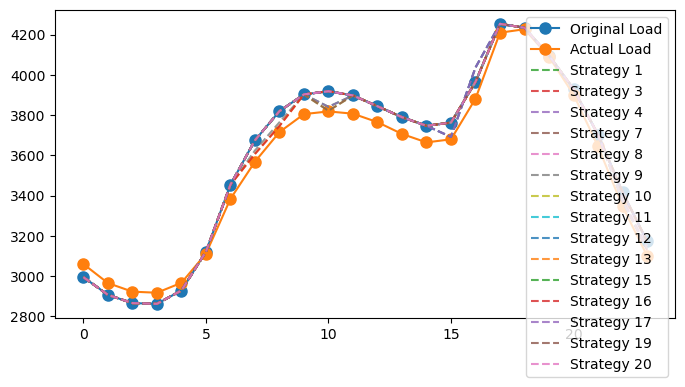

Found 1 relevant failed reflection cases for inquiry 26


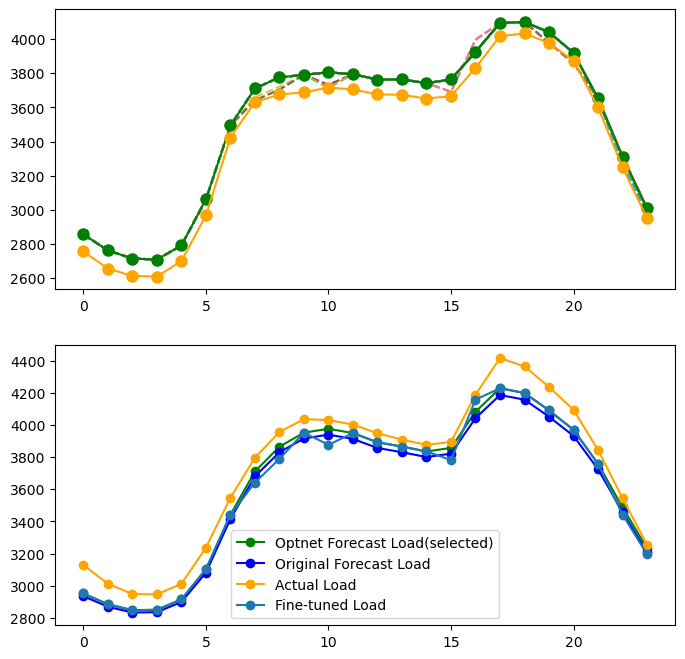

Original cost: 3186.672281882312, Optnet cost: 3041.048890065378, Fine-tuned cost: 3111.10381430914
Strategy generation attempt #1 (Current valid strategies: 0/5)
Found valid strategy strategy_4, cost 3169.51, original cost 3186.67, (reduction 17.16)
Found valid strategy strategy_8, cost 3178.56, original cost 3186.67, (reduction 8.11)
Strategy generation attempt #2 (Current valid strategies: 2/5)
Give actual value
Strategy generation attempt #3 (Current valid strategies: 2/5)
Give actual value
Found valid strategy strategy_3, cost 3180.84, original cost 3186.67, (reduction 5.83)
Found valid strategy strategy_5, cost 3168.86, original cost 3186.67, (reduction 17.82)
Found valid strategy strategy_6, cost 3183.11, original cost 3186.67, (reduction 3.57)
3026.2121817224393
2982.2353556601965
2969.566809815421


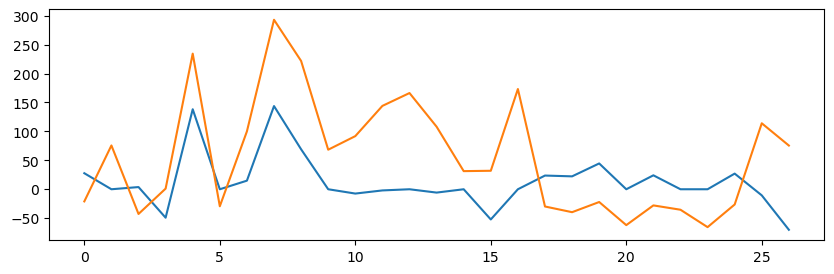

The following samples (inquire_id) did not complete LLM fine-tuning; original forecast curves were used: [1, 5, 9, 12, 14, 16, 20, 22, 23]
The following samples (inquire_id) failed to find effective strategies on validation set; original forecast curves were used: []
Processing inquiry 28/29
Found 3 similar days for inquiry 27
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Found valid strategy strategy_1, cost 2790.96, original cost 2813.66, (reduction 22.70)
Found valid strategy strategy_4, cost 2773.29, original cost 2813.66, (reduction 40.38)
Found valid strategy strategy_6, cost 2803.00, original cost 2813.66, (reduction 10.67)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Found valid strategy strategy_1, cost 2788.13, original cost 2813.66, (reduction 25.54)
Found valid strategy strategy_4, cost 2774.62, original cost 2813.66, (reduction 39.04)
Found valid strategy strategy_5, cost 2804.28, ori

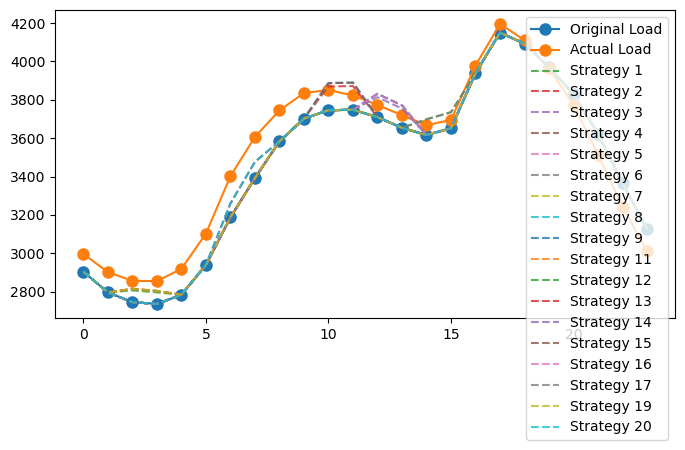

Found 1 relevant failed reflection cases for inquiry 27


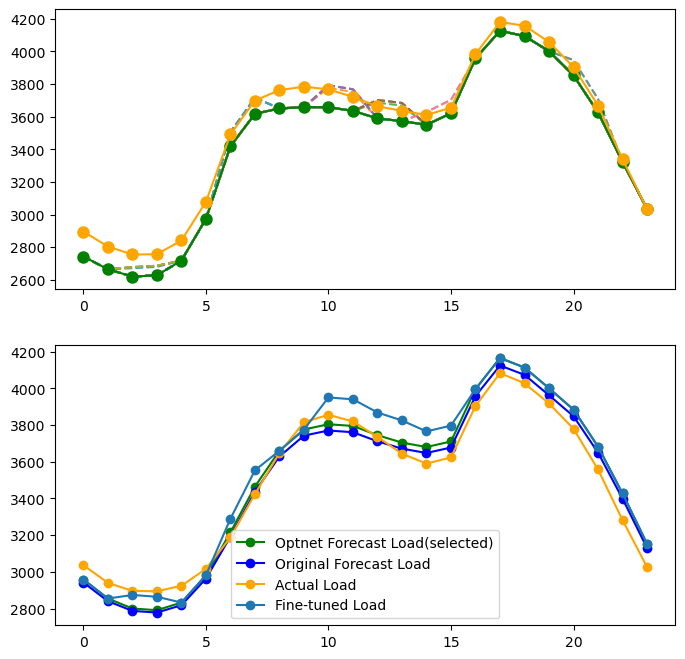

Original cost: 2672.6641789908763, Optnet cost: 2655.197208407897, Fine-tuned cost: 2656.7245919754064
Strategy generation attempt #1 (Current valid strategies: 0/5)
Found valid strategy strategy_1, cost 2652.46, original cost 2672.66, (reduction 20.21)
Found valid strategy strategy_2, cost 2657.65, original cost 2672.66, (reduction 15.02)
Found valid strategy strategy_4, cost 2670.37, original cost 2672.66, (reduction 2.29)
Strategy generation attempt #2 (Current valid strategies: 3/5)
Give actual value
Found valid strategy strategy_1, cost 2652.46, original cost 2672.66, (reduction 20.21)
Strategy generation attempt #3 (Current valid strategies: 4/5)
Give actual value
Found valid strategy strategy_1, cost 2652.01, original cost 2672.66, (reduction 20.65)
3013.585467339169
2970.5554218297575
2958.393873463992


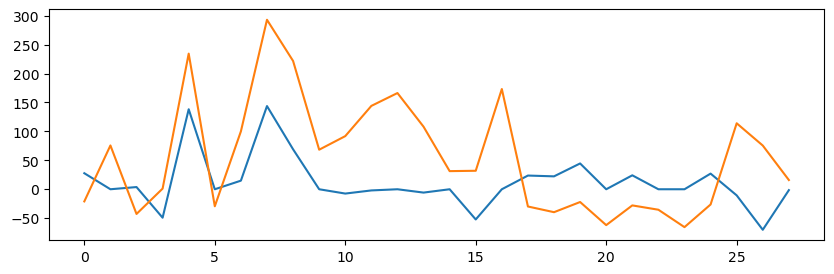

The following samples (inquire_id) did not complete LLM fine-tuning; original forecast curves were used: [1, 5, 9, 12, 14, 16, 20, 22, 23]
The following samples (inquire_id) failed to find effective strategies on validation set; original forecast curves were used: []
Processing inquiry 29/29
Found 3 similar days for inquiry 28
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Found valid strategy strategy_5, cost 2547.77, original cost 2569.26, (reduction 21.49)
Strategy generation attempt #2 (Current valid strategies: 1/20)
Found valid strategy strategy_8, cost 2544.21, original cost 2569.26, (reduction 25.05)
Strategy generation attempt #3 (Current valid strategies: 2/20)
Give actual value
Found valid strategy strategy_2, cost 2560.12, original cost 2569.26, (reduction 9.14)
Found valid strategy strategy_4, cost 2533.40, original cost 2569.26, (reduction 35.87)
Found valid strategy strategy_5, cost 2538.07, original c

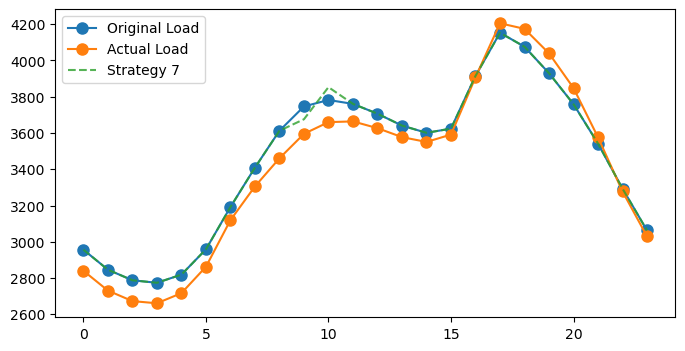

Found 1 relevant failed reflection cases for inquiry 28


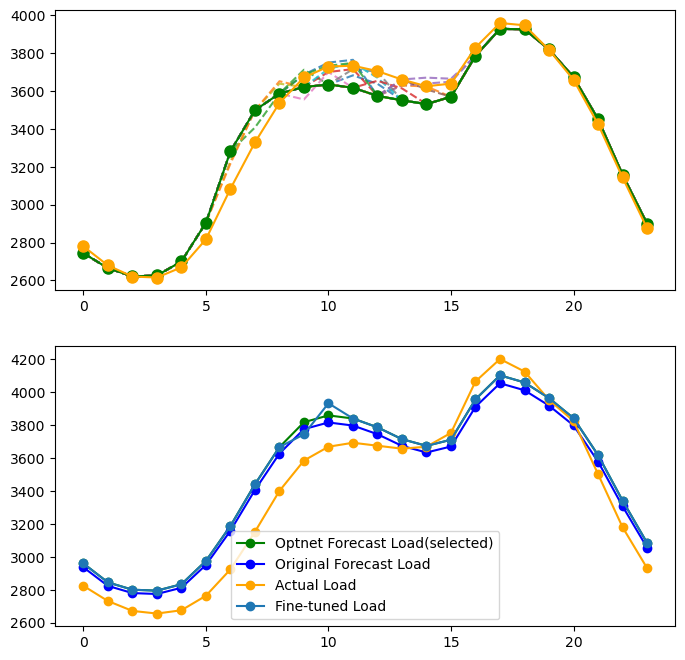

Original cost: 2679.8912035742314, Optnet cost: 2670.971867322264, Fine-tuned cost: 2669.885506820763
3002.078768588654
2960.2249544329475
2948.445309096984


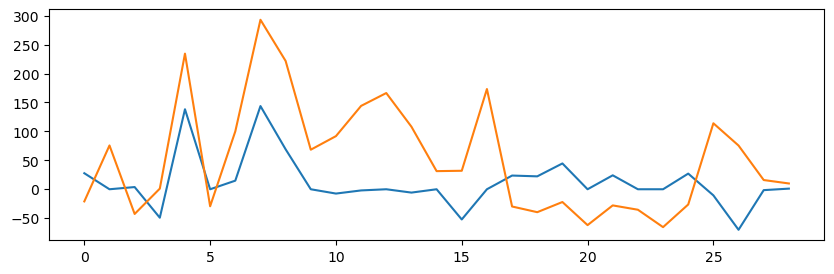

The following samples (inquire_id) did not complete LLM fine-tuning; original forecast curves were used: [1, 5, 9, 12, 14, 16, 20, 22, 23]
The following samples (inquire_id) failed to find effective strategies on validation set; original forecast curves were used: []


In [ ]:
fine_tuned_result_given_by_LLM = {
    'selected_flag': [], 'actual_load': [], 'original_mu': [], 'optnet_mu': [],
    'fine_tuned_mu': [], 'original_var': [], 'optnet_var': [],
    'fine_tuned_var': [], 'cost_after': [], 'cost_org': [], 'cost_optnet': [],
    'similar_mu': [], 'similar_var': [], 'similar_actual_load': [],
    'few_shot_costs': [], 'few_shot_curves': [], 'few_shot_code': [], 'strategy_code': []
}
skip_samples = []
validate_failures = []
reflection_records = []

for inqure_id in range(len(pred_mu_test_insert)):
    print(f"Processing inquiry {inqure_id+1}/{len(pred_mu_test_insert)}")
    data_for_inqure = {
        'load': pred_mu_test_insert[inqure_id],
        'fine_tuned_load': pred_mu_test_optnet_insert[inqure_id],
        'pred_var': pred_var_test_insert[inqure_id],
        'fine_tuned_var': pred_var_test_optnet_insert[inqure_id],
    }

    load_numpy_mu_org = np.array(data_for_inqure['load']) # train_load_data.scaler_y.inverse_transform(np.array(data_for_inqure['load']).reshape(1,-1))[0]
    load_numpy_var_org = np.array(data_for_inqure['pred_var']) # .reshape(1,-1)*train_load_data.scaler_y.scale_
    load_numpy_mu_optnet = np.array(data_for_inqure['fine_tuned_load']) # train_load_data.scaler_y.inverse_transform(np.array(data_for_inqure['fine_tuned_load']).reshape(1,-1))[0]
    load_numpy_var_optnet = np.array(data_for_inqure['fine_tuned_var']) # .reshape(1,-1)*train_load_data.scaler_y.scale_
    # actual_load_numpy= train_load_data.scaler_y.inverse_transform(np.array(data_for_inqure['fine_tuned_load']).reshape(1,-1))[0]
    actual_load_numpy = np.array(actual_load_test_insert[inqure_id])

    similar_days = db_train.get_top_k_unique_loads(data_for_inqure['load'], k=3, q=1)[0:3]
    average_similar_mu_org = np.mean([day['load'] for day in similar_days], axis=0)
    average_similar_var_org = np.mean([day['pred_var'] for day in similar_days], axis=0)
    average_similar_load_actual = np.mean([day['actual_load'] for day in similar_days], axis=0)
    average_similar_mu_optnet = np.mean([day['fine_tuned_load'] for day in similar_days], axis=0)
    average_similar_var_optnet = np.mean([day['fine_tuned_var'] for day in similar_days], axis=0)
    _, _, obj_org_similar_days = optimization_module.forward(average_similar_mu_org, average_similar_var_org, average_similar_load_actual)
    obj_org_similar_days = obj_org_similar_days.item()
    
    _, _, obj_optnet_similar_days = optimization_module.forward(average_similar_mu_optnet, average_similar_var_optnet, average_similar_load_actual)
    obj_optnet_similar_days = obj_optnet_similar_days.item()

    selected_flag = 'optnet'
    load_nor= data_for_inqure['fine_tuned_load'] 
    average_similar_mu = average_similar_mu_optnet
    average_similar_var = average_similar_var_optnet
    actual_load = average_similar_load_actual

    higher_flag = "higher" if sum(np.array(average_similar_mu) - np.array(actual_load)) > 0 else "lower"
    reduce_flag = "reduce" if higher_flag == "higher" else "increase"
    print(f"Found {len(similar_days)} similar days for inquiry {inqure_id}")
    system_prompt = generate_prompt_sys(args, data_for_inqure)

    full_user_prompt = f"SYSTEM INSTRUCTIONS:\n{system_prompt}."
    full_user_prompt += f"""\n\nHint: You have two approach to reduce cost:

    1. Compare the actual value and forecast of the similar day, try to learn some errors reduce strategy. In history similar day, we find the forecasts {higher_flag} than actual, so you can try to {reduce_flag} the load in some hours to reduce cost.
    2. Compare the future positive and negative reserve prices.
    - If the positive reserve price is much higher than the negative reserve price, you should schedule more generation in the day-ahead market.
    - If the negative reserve price is higher, schedule less generation to reduce potential costs.
    """

    # Few-shot code integration
    print("Generating few-shot prompts based on similar days...")
    strategy_history, valid_strategies = few_shot_prompt_generate(args, similar_days, max_strategies=20, max_attempts=6)
    
    selected_strategy = []
    similar_days_val = db_val.get_top_k_unique_loads(data_for_inqure['load'], k=3, q=1)[0:3]
    average_similar_mu_val = np.mean([day['load'] for day in similar_days_val], axis=0)
    average_similar_var_val = np.mean([day['pred_var'] for day in similar_days_val], axis=0)
    average_similar_load_actual_val = np.mean([day['actual_load'] for day in similar_days_val], axis=0)
    plt.figure(figsize=(8, 4))
    plt.plot(range(len(average_similar_mu_val)), average_similar_mu_val, markersize=8, marker='o', label='Original Load')
    plt.plot(range(len(average_similar_mu_val)), average_similar_load_actual_val, markersize=8, marker='o', label='Actual Load')
    
    load_val_numpy = average_similar_mu_val.tolist()
            
    load_val_nor = train_load_data.scaler_y.transform(np.array(load_val_numpy).reshape(-1,1)).flatten()
    if isinstance(train_load_data.scaler_y, StandardScaler):
        load_val_var_nor = np.array(average_similar_var_val).flatten()/train_load_data.scaler_y.scale_
    elif isinstance(train_load_data.scaler_y, MinMaxScaler):
        load_val_var_nor = np.array(average_similar_var_val).flatten()/(train_load_data.scaler_y.data_max_-train_load_data.scaler_y.data_min_)
    print('load_val_nor:', load_val_nor)
    print('load_val_var_nor:', load_val_var_nor)
    for strategy in valid_strategies:
        strategy_result = evaluate_individual_strategies(
            strategy['code'],
            load_val_nor,
            load_val_var_nor,
            max_change_percent=0.1
        )
        selected_curve_val = strategy_result[list(strategy_result.keys())[0]]['adjusted_curve']
        selected_curve_var_val = strategy_result[list(strategy_result.keys())[0]]['adjusted_curve_var']
        print('selected_curve_val:', selected_curve_val)
        print('selected_curve_var_val:', selected_curve_var_val)
        fine_tune_load_val_numpy = train_load_data.scaler_y.inverse_transform(np.array(selected_curve_val).reshape(-1,1)).flatten()
        if isinstance(train_load_data.scaler_y, StandardScaler):
            fine_tune_var_val_numpy = np.array(selected_curve_var_val).flatten()*train_load_data.scaler_y.scale_
        elif isinstance(train_load_data.scaler_y, MinMaxScaler):
            fine_tune_var_val_numpy = np.array(selected_curve_var_val).flatten()*(train_load_data.scaler_y.data_max_-train_load_data.scaler_y.data_min_)
        _, _, obj_org_val = optimization_module.forward(average_similar_mu_val, average_similar_var_val, average_similar_load_actual_val)
        _, _, obj_fine_tune_val = optimization_module.forward(fine_tune_load_val_numpy, fine_tune_var_val_numpy, average_similar_load_actual_val)

        if obj_org_val > obj_fine_tune_val:
            selected_strategy.append(strategy)
            plt.plot(range(24), fine_tune_load_val_numpy, label=strategy['name'], linestyle='--', alpha=0.8)
            print(f"Strategy {strategy['name']} succeeded on validation set, cost {obj_fine_tune_val.item():.2f}, original cost {obj_org_val.item():.2f}, (reduction {obj_org_val.item()-obj_fine_tune_val.item():.2f})")
        else:
            print(f"Strategy {strategy['name']} failed on validation set, cost {obj_fine_tune_val.item():.2f}, original cost {obj_org_val.item():.2f}, (increase {obj_org_val.item()-obj_fine_tune_val.item():.2f})")
    plt.legend()
    plt.show()

    # If no valid fine-tuning strategy is found, skip directly
    if len(selected_strategy) == 0:
        print(f"Inquiry {inqure_id}: No valid strategy found, using original curve as fine-tuned result.")
        # _, _, obj_org = optimization_module.forward(average_similar_mu_val,average_similar_var_val, average_similar_load_actual_val)
        # _, _, obj_optnet = optimization_module.forward(average_similar_mu_val,average_similar_var_val, average_similar_load_actual_val)

        _,_, obj_org = optimization_module.forward(load_numpy_mu_org, load_numpy_var_org, actual_load_numpy)
        _,_, obj_optnet = optimization_module.forward(load_numpy_mu_optnet, load_numpy_var_optnet, actual_load_numpy)

        if selected_flag == 'org':
            fine_tuned_result_given_by_LLM['fine_tuned_mu'].append(data_for_inqure['load'])
            fine_tuned_result_given_by_LLM['fine_tuned_var'].append(data_for_inqure['pred_var'])
            fine_tuned_result_given_by_LLM['cost_after'].append(obj_org.item())
        else:
            fine_tuned_result_given_by_LLM['fine_tuned_mu'].append(data_for_inqure['fine_tuned_load'])
            fine_tuned_result_given_by_LLM['fine_tuned_var'].append(data_for_inqure['fine_tuned_var'])
            fine_tuned_result_given_by_LLM['cost_after'].append(obj_optnet.item())

        fine_tuned_result_given_by_LLM['selected_flag'].append(selected_flag)
        fine_tuned_result_given_by_LLM['actual_load'].append(actual_load_test_insert[inqure_id])
        fine_tuned_result_given_by_LLM['original_mu'].append(data_for_inqure['load'])
        fine_tuned_result_given_by_LLM['optnet_mu'].append(data_for_inqure['fine_tuned_load'])
        fine_tuned_result_given_by_LLM['original_var'].append(data_for_inqure['pred_var'])
        fine_tuned_result_given_by_LLM['optnet_var'].append(data_for_inqure['fine_tuned_var'])
        fine_tuned_result_given_by_LLM['similar_mu'].append(average_similar_mu_org.tolist())
        fine_tuned_result_given_by_LLM['similar_var'].append(average_similar_var_org.tolist())
        fine_tuned_result_given_by_LLM['similar_actual_load'].append(average_similar_load_actual.tolist())
        fine_tuned_result_given_by_LLM['cost_org'].append(obj_org.item())
        fine_tuned_result_given_by_LLM['cost_optnet'].append(obj_optnet.item())
        fine_tuned_result_given_by_LLM['few_shot_costs'].append([])
        fine_tuned_result_given_by_LLM['few_shot_curves'].append([])
        fine_tuned_result_given_by_LLM['few_shot_code'].append([])
        fine_tuned_result_given_by_LLM['strategy_code'].append('')
        skip_samples.append(inqure_id)
        
        # Visualization
        if len(fine_tuned_result_given_by_LLM['cost_org']) > 1:
            print(np.mean(fine_tuned_result_given_by_LLM['cost_org']))
            print(np.mean(fine_tuned_result_given_by_LLM['cost_optnet']))
            print(np.mean(fine_tuned_result_given_by_LLM['cost_after']))
            plt.figure(figsize=(8, 3))
            plt.plot(
                range(len(fine_tuned_result_given_by_LLM['cost_org'])),
                np.array(fine_tuned_result_given_by_LLM['cost_optnet']) - np.array(fine_tuned_result_given_by_LLM['cost_after']),
                label='Compared to optnet'
            )
            plt.plot(
                range(len(fine_tuned_result_given_by_LLM['cost_org'])),
                np.array(fine_tuned_result_given_by_LLM['cost_org']) - np.array(fine_tuned_result_given_by_LLM['cost_after']),
                label='Compared to original'
            )
            plt.show()
            plt.close()
        continue

    # Construct few-shot LLM prompt
    few_shot_costs = [s['final_cost'] for s in selected_strategy]
    few_shot_curves = [s['adjusted_curve'] for s in selected_strategy]
    few_shot_codes = [s['code'] for s in selected_strategy]
    history_snippet_prompt = 'Here are some previously discovered effective adjustment strategies:\n'
    for i, s in enumerate(selected_strategy):
        history_snippet_prompt += f"Good strategy {i+1} from few-shot:\n{s['code']}\n\n"
    history_snippet_prompt += f"You should ensemble these strategy as you can only output one adjustment_strategy function.\n"

    last_fail_reflections = get_fail_reflections_by_curve_distance(reflection_records, data_for_inqure['load'], max_num=1)
    print(f"Found {len(last_fail_reflections)} relevant failed reflection cases for inquiry {inqure_id}")
    fail_reflections_prompt = ""
    if last_fail_reflections:
        fail_reflections_prompt = 'You have failed in these examples and lead to cost increase, avoid these patterns:\n'
        fail_reflections_prompt += "\n### Previous failed adjustment text examples (avoid these patterns):\n"
        for idx, record in enumerate(last_fail_reflections):
            fail_reflections_prompt += (
                f"Fail Case {idx + 1}:\n"
                f"- Last failed strategy:\n{remove_comments(record['strategy_code'])}\n\n"
                f"- Successful strategy:\n{(record['reflection_strategy'])}\n\n"
            )

    if args.LLM_type == 'Qwen':
        response = Generation.call(
            model="qwen-plus",
            messages=[
            #    {"role": "system", "content": full_user_prompt},
                {"role": "user", "content": output_require_prompt},
                {"role": "assistant", "content": history_snippet_prompt},
                {"role": "assistant", "content": fail_reflections_prompt},
            ],
            parameters={
                "temperature": 0.1,
                "result_format": "text",
                "max_tokens": 2048,
                "top_k": 10
            }
        )

        raw_text = response.output.text.strip()
        func_code = extract_pure_code(raw_text)

    elif args.LLM_type == 'Deepseek':
        client = OpenAI(api_key=DEEPSEEK_API_KEY,
                base_url="https://api.deepseek.com")
        
        response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
            {"role": "system", "content": full_user_prompt},
            {"role": "user", "content": output_require_prompt},
            {"role": "assistant", "content": history_snippet_prompt},
            {"role": "assistant", "content": fail_reflections_prompt},
        ],
        temperature=0.1,
        max_tokens=2048,
        stream=False,
        )
    
        raw_text = response.choices[0].message.content.strip()
        func_code = extract_pure_code(raw_text)

    elif args.LLM_type == 'Llama':
        client = Together(api_key=LLAMA_API_KEY)
        response = client.chat.completions.create(
            model="meta-llama/Llama-4-Scout-17B-16E-Instruct",  # Can be replaced with other Llama versions
            messages=[
        #    {"role": "system", "content": full_user_prompt},
            {"role": "user", "content": output_require_prompt},
            {"role": "assistant", "content": history_snippet_prompt},
            {"role": "assistant", "content": fail_reflections_prompt},
        ],
        temperature=0.1,
        max_tokens=2048,
        )
        raw_text = response.choices[0].message.content.strip()
        func_code = extract_pure_code(raw_text)
        

    if selected_flag == 'org':
        load_org_nor = train_load_data.scaler_y.transform(np.array(data_for_inqure['load']).reshape(-1,1)).flatten()
        if isinstance(train_load_data.scaler_y, StandardScaler):
            load_org_var_nor = data_for_inqure['pred_var']*train_load_data.scaler_y.scale_
        elif isinstance(train_load_data.scaler_y, MinMaxScaler):
            load_org_var_nor = data_for_inqure['pred_var']*(train_load_data.scaler_y.data_max_-train_load_data.scaler_y.data_min_)
        
        selected_curve, selected_var, delta_curve, strategy_code = execute_strategy_function(
            func_code,
            load_org_nor,
            load_org_var_nor,
            max_change_percent=0.1
        )

    else:
        fine_tuned_load_nor = train_load_data.scaler_y.transform(np.array(data_for_inqure['fine_tuned_load']).reshape(-1,1)).flatten()
        # if isinstance(train_load_data.scaler_y, StandardScaler):
        #    fine_tuned_load_var_nor= data_for_inqure['fine_tuned_var']*train_load_data.scaler_y.scale_
        # elif isinstance(train_load_data.scaler_y, MinMaxScaler):
        #    fine_tuned_load_var_nor= data_for_inqure['fine_tuned_var']*(train_load_data.scaler_y.data_max_-train_load_data.scaler_y.data_min_)
        selected_curve, selected_var, delta_curve, strategy_code = execute_strategy_function(
            func_code,
            fine_tuned_load_nor,
            data_for_inqure['fine_tuned_var'],
            max_change_percent=0.1
        )
    # print(selected_curve,fine_tuned_load_nor)
    fine_tune_load_numpy = train_load_data.scaler_y.inverse_transform(np.array(selected_curve).reshape(1, -1))[0]
    # if isinstance(train_load_data.scaler_y, StandardScaler):
    #     fine_tune_var_numpy = np.array(selected_var).flatten()*train_load_data.scaler_y.scale_
    # elif isinstance(train_load_data.scaler_y, MinMaxScaler):
    #     fine_tune_var_numpy = np.array(selected_var).flatten()*(train_load_data.scaler_y.data_max_-train_load_data.scaler_y.data_min_)
    # print(selected_var,fine_tune_var_numpy)
    _, _, obj_org = optimization_module.forward(load_numpy_mu_org, load_numpy_var_org, actual_load_numpy)
    _, _, obj_optnet = optimization_module.forward(load_numpy_mu_optnet, load_numpy_var_optnet, actual_load_numpy)
    # print(fine_tune_load_numpy,selected_var)
    # print(load_numpy_mu_optnet,fine_tune_load_numpy)
    _, _, obj_fine_tune = optimization_module.forward(fine_tune_load_numpy, selected_var, actual_load_numpy)

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    for i in valid_strategies:
        plt.plot(i['adjusted_curve'], label=i['name'], linestyle='--', alpha=0.8)
    if selected_flag == 'org':
        plt.plot(range(24), i['original_load'], markersize=8, marker='o', label='Original Load', color='blue')
    else:
        plt.plot(range(24), i['original_load'], markersize=8, marker='o', label='Optnet Load', color='green')
    plt.plot(range(24), i['actual_load'], markersize=8, marker='o', label='Actual Load', color='orange')
    # plt.legend()

    plt.subplot(2, 1, 2)
    if selected_flag == 'org':
        plt.plot(range(24), data_for_inqure['load'], label='Original Forecast Load(selected)', marker='o', color='blue')
        plt.plot(range(24), data_for_inqure['fine_tuned_load'], label='Optnet Forecast Load', marker='o', color='green')
    else:
        plt.plot(range(24), data_for_inqure['fine_tuned_load'], label='Optnet Forecast Load(selected)', marker='o', color='green')
        plt.plot(range(24), data_for_inqure['load'], label='Original Forecast Load', marker='o', color='blue')
    plt.plot(range(24), actual_load_test_insert[inqure_id], label='Actual Load', marker='o', color='orange')
    plt.plot(range(24), fine_tune_load_numpy, label='Fine-tuned Load', marker='o')
    plt.legend()
    plt.show()
    print(f"Original cost: {obj_org.item()}, Optnet cost: {obj_optnet.item()}, Fine-tuned cost: {obj_fine_tune.item()}")

    reflection_strategy = ""
    if selected_flag == 'org' and obj_fine_tune.item() < obj_org.item():
            reflection_strategy = "Cost reduction achieved."
            insight = f"Successfully reduced cost by {obj_org.item() - obj_fine_tune.item():.2f}."
    elif selected_flag == 'org' and obj_fine_tune.item() > obj_org.item():
        failures = [{"inqure_id": inqure_id,
            "load": data_for_inqure['load'],
            "actual_load": actual_load_test_insert[inqure_id],
            'fine_tuned_load': selected_curve,
            "cost_before": obj_org.item(),
            "cost_after": obj_fine_tune.item(),
            "strategy_code": strategy_code,
        }]

        reflection_strategy_history, reflection_valid_strategies = few_shot_prompt_generate(args, failures, max_strategies=5, max_attempts=3)
        reflection_strategy = f"For this failure cases, consider:"
        for i in range(len(reflection_valid_strategies)):
            strategy = reflection_valid_strategies[i]
            reflection_strategy += f"Success strategy {i} for failure case:\n{remove_comments(strategy['code'])}\n"

    if selected_flag == 'optnet' and obj_fine_tune.item() < obj_optnet.item():
            reflection_strategy = "Cost reduction achieved."
            insight = f"Successfully reduced cost by {obj_optnet.item() - obj_fine_tune.item():.2f}."
    elif selected_flag == 'optnet' and obj_fine_tune.item() > obj_optnet.item():
        failures = [{"inqure_id": inqure_id,
            "load": data_for_inqure['load'],
            'pred_var': data_for_inqure['pred_var'],
            "actual_load": actual_load_test_insert[inqure_id],
            'fine_tuned_load': selected_curve,
            'fine_tuned_var': data_for_inqure['fine_tuned_var'],
            "cost_before": obj_optnet.item(),
            "cost_after": obj_fine_tune.item(),
            "strategy_code": strategy_code,
        }]

        reflection_strategy_history, reflection_valid_strategies = few_shot_prompt_generate(args, failures, max_strategies=5, max_attempts=3,failure_strategy=strategy_code)
        reflection_strategy = f"For this failure cases, consider:"
        for i in range(len(reflection_valid_strategies)):
            strategy = reflection_valid_strategies[i]
            reflection_strategy += f"Success strategy {i} for failure case:\n{remove_comments(strategy['code'])}\n"

    reflection_records.append({
        "inquiry_id": inqure_id,
        "original_load": data_for_inqure['load'],
        "actual_load": actual_load_test_insert[inqure_id],
        "fine_tuned_load": data_for_inqure['fine_tuned_load'],
        "cost_before": obj_org.item(),
        "cost_after": obj_fine_tune.item(),
        "strategy_code": strategy_code,
        "reflection_strategy": reflection_strategy,
        "similar_day_comparison": f"Similar days showed forecast was {higher_flag} than actual"
    })
    reflection_records = reflection_records[-10:]  # Keep only the last 10 records

    fine_tuned_result_given_by_LLM['selected_flag'].append(selected_flag)
    fine_tuned_result_given_by_LLM['actual_load'].append(actual_load_test_insert[inqure_id])
    fine_tuned_result_given_by_LLM['original_mu'].append(data_for_inqure['load'])
    fine_tuned_result_given_by_LLM['optnet_mu'].append(data_for_inqure['fine_tuned_load'])
    fine_tuned_result_given_by_LLM['fine_tuned_mu'].append(fine_tune_load_numpy)
    fine_tuned_result_given_by_LLM['original_var'].append(data_for_inqure['pred_var'])
    fine_tuned_result_given_by_LLM['optnet_var'].append(data_for_inqure['fine_tuned_var'])
    fine_tuned_result_given_by_LLM['fine_tuned_var'].append(selected_var)
    fine_tuned_result_given_by_LLM['cost_after'].append(obj_fine_tune.item())
    fine_tuned_result_given_by_LLM['cost_org'].append(obj_org.item())
    fine_tuned_result_given_by_LLM['cost_optnet'].append(obj_optnet.item())

    fine_tuned_result_given_by_LLM['similar_mu'].append(average_similar_mu_org.tolist())
    fine_tuned_result_given_by_LLM['similar_var'].append(average_similar_var_org.tolist())
    fine_tuned_result_given_by_LLM['similar_actual_load'].append(average_similar_load_actual.tolist())
    fine_tuned_result_given_by_LLM['few_shot_costs'].append(few_shot_costs)
    fine_tuned_result_given_by_LLM['few_shot_curves'].append(few_shot_curves)
    fine_tuned_result_given_by_LLM['few_shot_code'].append(few_shot_codes)
    fine_tuned_result_given_by_LLM['strategy_code'].append(strategy_code)

    if len(fine_tuned_result_given_by_LLM['cost_org']) > 1:
        print(np.mean(fine_tuned_result_given_by_LLM['cost_org']))
        print(np.mean(fine_tuned_result_given_by_LLM['cost_optnet']))
        print(np.mean(fine_tuned_result_given_by_LLM['cost_after']))
        plt.figure(figsize=(10, 3))
        plt.plot(
            range(len(fine_tuned_result_given_by_LLM['cost_org'])),
            np.array(fine_tuned_result_given_by_LLM['cost_optnet']) - np.array(fine_tuned_result_given_by_LLM['cost_after']),
            label='Compared to optnet'
        )
        plt.plot(
            range(len(fine_tuned_result_given_by_LLM['cost_org'])),
            np.array(fine_tuned_result_given_by_LLM['cost_org']) - np.array(fine_tuned_result_given_by_LLM['cost_after']),
            label='Compared to original'
        )

        plt.show()
        plt.close()

    print(f"The following samples (inquire_id) did not complete LLM fine-tuning; original forecast curves were used: {skip_samples}")
    print(f"The following samples (inquire_id) failed to find effective strategies on validation set; original forecast curves were used: {validate_failures}")

    with open('../Result/NN+SO/'+args.LLM_type+'.pkl', 'wb') as f:
        pickle.dump(fine_tuned_result_given_by_LLM, f)

### result

In [79]:
print(np.mean(fine_tuned_result_given_by_LLM['cost_org']))
print(np.mean(fine_tuned_result_given_by_LLM['cost_optnet']))
print(np.mean(fine_tuned_result_given_by_LLM['cost_after']))

3002.078768588654
2960.2249544329475
2948.445309096984


In [80]:
with open('../Result/NN+SO/'+args.LLM_type+'.pkl', 'wb') as f:
    pickle.dump(fine_tuned_result_given_by_LLM, f)